In [737]:
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
#from captum.attr import IntegratedGradients
from NegativeClassOptimization.preprocessing import *
from NegativeClassOptimization import ml
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import copy
from itertools import combinations

In [738]:
import warnings
warnings.filterwarnings("ignore")


In [1117]:
import ast


In [739]:
tasks = ['ONE_VS_NINE', 'HIGH_VS_95LOW', 'HIGH_VS_LOOSER']
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}
mut_path = Path('../data/mutated_t6')

In [740]:
def get_color(task):
    if task == 'ONE_VS_NINE' :
        color= '#FF5733'
    elif task == 'HIGH_VS_95LOW':
        color = '#00A6ED'
    else:
        color = '#FFC300'
    return color

## Finding correct mutants, i.e without shifts inside Slide

Mutant data is taken from Absolut! task 6. Now all mutant data is located in folder ../data/mutated_t6/{Antigen}/PooledTempResults_merged.txt
The were obtained from simulation folder which can be found in ListTask6_v29_dec.txt

The first colum "ID_slide_Variant" in "PooledTempResults_merged.txt" (ex: H_H152542_00a_0m_0_00a) contains information on: which was the original sequence (H152542), how many mutations _2m_4 : 2 mutations, variant 4

In [741]:
def find_ids(ID):
    try:
        first_id = re.match('[A-Z_]*([0-9]+_[0-9]*[a-z])',ID).group(1)
        return first_id
    except:
        return 'unknown'

In [743]:
#get number of mutations from ID slide Variant
#! actually \dm does not always reflect the correcr number of mutations in Slide since it shows mutations in CDR3
def get_mutations(ID):
    try:
        n_mut = re.search('([0-9])m',ID).group(1)
        return int(n_mut)
    except:
        return np.NaN

In [804]:
def prep_mut_df(mut_folder):
    mut_file = pd.read_csv(mut_path / f'{mut_folder}/PooledTempResults_merged.txt', sep=' ')
    mut_file['n_mut'] = mut_file['ID_slide_Variant'].apply(get_mutations)
    mut_file['ID'] = mut_file['ID_slide_Variant'].apply(find_ids)
    return mut_file

In [805]:
# find mutated slides corresponding to slides from test set
def get_org_slide_id(mut_file, wt_path): 
#! think about wt path, right now it is 'vs 9' test. Maybe it should be all binders 'MascotteSlices'. I keep test data as wt, so that mutatnts are close to test in terms of sequence
    wt_file = pd.read_csv(wt_path, sep='\t')
    wt_test = wt_file[wt_file['y'] == 1]
    wt_slides = set(wt_test.Slide)
    int_slides = set(mut_file[mut_file['n_mut'] == 0]['Slide']).intersection(wt_slides)
    slide_id = mut_file[mut_file['Slide'].isin(int_slides) & (mut_file['n_mut']==0)][['Slide', 'ID', 'Energy']]
    return slide_id

In [21]:
"""# find mutated slides corresponding to slides from test set
def get_org_slide_id_new(mut_file, wt_path): 
#! think about wt path, right now it is 'vs 9' train. Maybe it should be all binders 'MascotteSlices'
    wt_file = pd.read_csv(wt_path, sep='\t', header = 1)
    wt_slides = set(wt_file.Slide)
    int_slides = set(mut_file[mut_file['n_mut'] == 0]['Slide']).intersection(wt_slides)
    slide_id = mut_file[mut_file['Slide'].isin(int_slides) & (mut_file['n_mut']==0)][['Slide', 'ID', 'Energy']]
    return slide_id"""

## Experimental zone. 

In [13]:
ag = '1ADQ'
wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
mut_file = prep_mut_df(ag)

df_id_old = get_org_slide_id(mut_file, wt_path)

In [302]:
wt_path = '../data/full_data/divided2classes/1ADQ_AAnalyses/1ADQ_A_MascotteSlices.txt'
df_id_new = get_org_slide_id_new(mut_file, wt_path)

In [15]:
len(df_id_old)

59

In [24]:
len(df_id_new)

887

I tnink we shoul switch to all Slides mutants.
### End of experimental zone

In [813]:
def get_mut_patterns(slide, n_mut):
    seq = list(slide)
    pos = np.arange(0, 11)
    substitutions = []
    for n in n_mut:
        patterns = list(combinations(pos, n))
        substitutions.extend(patterns)

    res = []
    for sub in substitutions:
        seq_copy = copy.deepcopy(seq)
        for i in sub:
            seq_copy[i] = f'[^{seq_copy[i]}]'
        res.append((sub,''.join(seq_copy)))
    return res


In [814]:
def attr_from_oh(oh_slide, attr, baseline_type):
    oh_slide = np.array(oh_slide)
    oh_slide = torch.tensor(oh_slide).float()
    x_attr = attr.attribute(oh_slide)
    x_attr_stack = x_attr.reshape((11, 20))
    attr_aa = x_attr_stack[oh_slide.reshape((-1, 11, 20)).squeeze() == 1].squeeze().tolist()  # Nx11
    return attr_aa

In [923]:
#return here
def get_valid_mut(mut_file, slide_id, n_mut=3):
    dfs_list = []
    n_mut = np.arange(1,n_mut+1)
    for slide, ID, Energy in  slide_id.values:
        mut_patterns = get_mut_patterns(slide, n_mut) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut'].isin(n_mut)) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for mut_pos, pattern in mut_patterns:
            df_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_mut['dEnergy'] = [Energy]*df_mut.shape[0] - df_mut['Energy']
            df_mut['mut positions'] = [list(mut_pos)]*df_mut.shape[0]
            df_mut['n_mut'] = df_mut['mut positions'].apply(len)
            dfs_list.append(df_mut)
    return pd.concat(dfs_list)

def mutant_df_attr(df_mut, attr, baseline_type ='shuffle'):
    df_mut['mut OH'] = df_mut['Slide'].apply(lambda x: [onehot_encode(x)])
    df_mut['attr mut'] = df_mut['mut OH'].apply(lambda x: attr_from_oh(x,attr,baseline_type))
    #will have to attribute orriginal slide as well
    df_wt = pd.DataFrame({"original Slide": df_mut['original Slide'].unique()})
    df_wt['OH'] = df_wt["original Slide"].apply(lambda x: [onehot_encode(x)])
    df_wt['attr'] = df_wt['OH'].apply(lambda x: attr_from_oh(x,attr,baseline_type))
    dict_wt_attr = dict(zip(df_wt['original Slide'].values, df_wt['attr'].values))
    df_mut['attr wt'] = df_mut['original Slide'].apply(lambda x: dict_wt_attr[x])
    return df_mut

## Exploratory zone 

In [115]:
task = tasks[0]
seed_id = 0
split_id = 42

In [116]:
model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"

In [132]:
#need to create function that 
#model = ml.NCOModel(model_path)
model = torch.load(model_path)

In [133]:
model_snn = ml.SNN(10)
model_snn.linear_1 = model.module.linear_1
model_snn.linear_2 = model.module.linear_2

In [134]:
#sanity check
model_snn.linear_1 == model.module.linear_1

True

In [135]:
model_snn.linear_2 == model.module.linear_2

True

In [ ]:
def swa_model_to_snn(model_path):
    model = torch.load(model_path)
    model_snn = ml.SNN(10)
    model_snn.linear_1 = model.module.linear_1
    model_snn.linear_2 = model.module.linear_2
    return model_snn

    

In [136]:
attributor = ml.Attributor(model_snn,
            type="deep_lift", 
            baseline_type="shuffle",
            compute_on="logits",
            multiply_by_inputs=False,)

In [137]:
x = [onehot_encode(mut_file.iloc[0].Slide)]
x_tensor = torch.tensor(np.array(x, dtype=float)).float()

In [154]:
x_attr = attributor.attribute(x_tensor, return_baseline=False)

In [155]:
x_attr_stack = x_attr.reshape((11, 20))

In [160]:
x_attr_stack

tensor([[-2.1228e+00,  2.0677e+00, -6.9528e+00, -8.8069e+00,  2.5759e+00,
         -1.9851e+00, -2.2862e+00,  5.1107e-01, -7.9307e+00,  1.5150e+00,
          1.1532e+00, -5.3309e+00, -5.5376e+00, -5.8749e+00, -9.8203e+00,
         -3.2327e+00, -3.2954e+00,  3.8566e-01,  5.3837e-01, -1.0376e+00],
        [-8.7387e-01, -3.7820e-02, -3.2021e+00, -2.7356e+00, -1.8060e+00,
         -1.6124e+00, -4.5675e-01, -1.6954e+00, -1.7937e+00, -1.0454e+00,
          1.2664e+00, -1.3581e+00, -1.8380e+00, -8.8003e-01, -1.0008e+00,
         -2.5338e+00, -1.1594e+00,  3.3699e-01, -5.9973e-01, -3.1159e-01],
        [ 3.4485e-01, -7.0434e-01,  7.0461e-01,  7.8892e-01, -6.5928e+00,
          7.2904e-01, -1.1268e+00, -6.3616e+00,  1.3075e+00, -5.1688e+00,
         -5.7806e+00,  5.6657e-01,  1.1067e+00, -2.4019e-01,  2.3063e-01,
          1.1988e+00,  1.0465e+00, -3.3978e+00, -4.0974e+00, -3.3954e+00],
        [-2.7834e+00, -3.5779e-01, -4.8904e+00, -5.0704e+00,  1.3945e+00,
         -2.4810e+00, -3.1324e+00, 

In [166]:
attr_aa = x_attr_stack[x_tensor.reshape((-1, 11, 20)).squeeze() == 1].reshape(-1, 11)  # Nx11

In [167]:
attr_aa

tensor([[ 2.0677e+00,  3.3699e-01,  2.3063e-01, -3.7673e+00, -1.0820e+00,
          3.9372e+00,  3.4042e+00,  4.6826e+00, -2.3171e-03, -3.2558e-01,
          4.3836e+00]])

### End of exploritary zone

## Finding and saving wt IDs

In [807]:
for ag in config.ANTIGENS:
    print(ag)
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
    mut_file = prep_mut_df(ag)
    slide_id_df = get_org_slide_id(mut_file, wt_path)
    slide_id_df.to_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv')

3VRL
1NSN
3RAJ
5E94
1H0D
1WEJ
1ADQ
1FBI
2YPV
1OB1


In [ ]:
def get_binding_class_energies(ag):
    binder_path = glob.glob(f'../data/full_data/divided2classes/{ag}_*Analyses/{ag}_*_MascotteSlices.txt')[0]
    weak_path = glob.glob(f'../data/full_data/divided2classes/{ag}_*Analyses/{ag}_*_LooserSlices.txt')[0]
    df_binder = pd.read_csv(binder_path, sep='\t', header=1)
    df_weak = pd.read_csv(weak_path, sep='\t', header=1)
    binder_max_eng = df_binder.Energy.max()
    non_binder_min_eng = df_weak.Energy.max()
    return binder_max_eng, non_binder_min_eng

def get_binding_class(x, binder_max_eng, non_binder_min_eng):
    if x <= binder_max_eng:
        return 'Binder'
    elif x <= non_binder_min_eng:
        return 'Weak'
    else:
        return 'Non-binder'

In [840]:
#get_valid_mut 1-3
for ag in config.ANTIGENS:
    print(ag)
    slide_id_df = pd.read_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv', index_col=0)
    mut_file = prep_mut_df(ag)
    df_mut = get_valid_mut(mut_file, slide_id_df, n_mut=3)
    df_mut.drop_duplicates('Slide', inplace=True)
    binder_max_eng, non_binder_min_eng = get_binding_class_energies(ag)
    df_mut['binding class'] = df_mut.Energy.apply(lambda x: get_binding_class(x, binder_max_eng, non_binder_min_eng))
    df_mut.to_csv(f'./mutant_igs/{ag}_1-3mut.csv', index=False)

3VRL


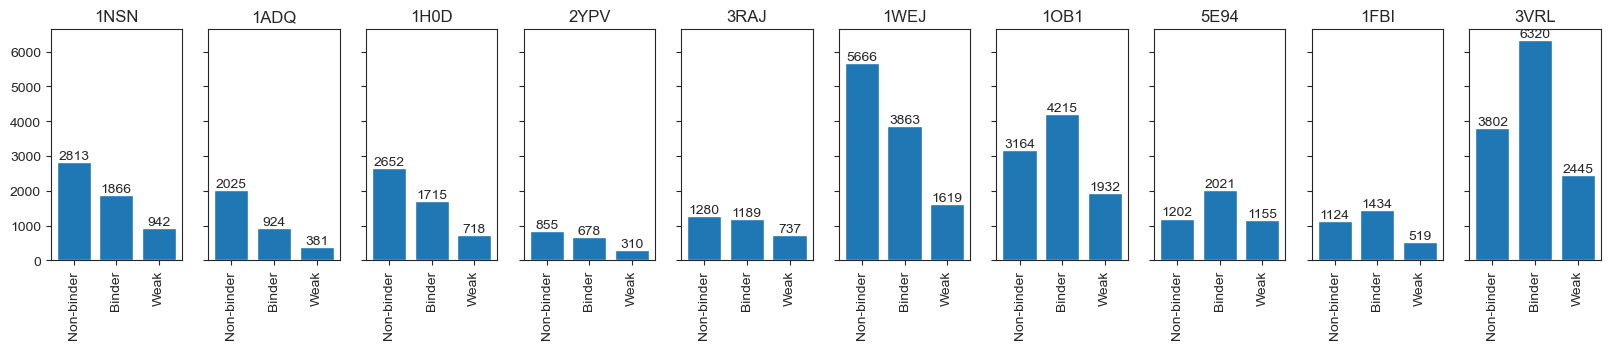

In [842]:
#what if I annotate only those that I've been working with so far?
#let's first join them
fig, ax = plt.subplots(ncols =10, figsize = (20,3), sharey=True, sharex=True)
for i,ag in enumerate(ag_order):
    pd_mut = pd.read_csv(f'./mutant_igs/{ag}_1-3mut.csv')
    pd_class_counts = pd_mut['binding class'].value_counts()
    ax[i].bar(pd_class_counts.index, pd_class_counts.values, )
    ax[i].tick_params(axis='x', labelrotation=90)
    ax[i].set_title(f'{ag}')
    
    ax[i].text(1, pd_class_counts['Binder'] + 0.5, str(pd_class_counts['Binder']), ha='center', va='bottom')
    ax[i].text(0, pd_class_counts['Non-binder'] + 0.5, str(pd_class_counts['Non-binder']), ha='center', va='bottom')
    ax[i].text(2, pd_class_counts['Weak'] + 0.5, str(pd_class_counts['Weak']), ha='center', va='bottom')


In [846]:
pd.read_csv(energy_contr_path)

,#Antigen 3VRL
0,ID\tCDR3Sequence\tBestForThisCDR?('true'/'fals...
1,SHH17238587_00a_1m_174_01a\tCCRIGLLLRVFDYW\tfa...
2,SHH17238587_00a_1m_175_01a\tCDRIGLLLRVFDYW\tfa...
3,SHH17238587_00a_1m_176_01a\tCERIGLLLRVFDYW\tfa...
4,SHH17238587_00a_1m_177_01a\tCHRIGLLLRVFDYW\tfa...
...,...
6573,H_H1698108_05a_1m_66_01a\tCARRCWLLLGWNFDVW\tfa...
6574,H_H1698108_05a_1m_67_01a\tCARRCWLLLGWRFDVW\tfa...
6575,H_H1698108_05a_1m_68_01a\tCARRCWLLLGWSFDVW\tfa...
6576,H_H1698108_05a_1m_69_01a\tCARRCWLLLGWTFDVW\tfa...


In [848]:
#see if I have sufficient intersection between mutants and energy attribution file
for ag in config.ANTIGENS:
    energy_contr_path = f'../data/mutant_energy_contributions/{ag}_HIGH_VS_LOOSER_mut_igs_energy_contributions_input.tsv'
    pd_mut_slides = set(pd.read_csv(f'./mutant_igs/{ag}_1-3mut.csv')['Slide'].values)
    eng_attr_slides =  set(pd.read_csv(energy_contr_path, sep='\t', header=1)['Slide'].values)
    n_int = len(pd_mut_slides.intersection(eng_attr_slides))
    n = len(pd_mut_slides)
    int_perc = n_int/n*100
    print(ag, int_perc,'%')

3VRL 52.20020689106389 %
1NSN 53.8694182529799 %
3RAJ 53.55583281347474 %
5E94 54.61397898583829 %
1H0D 52.11406096361848 %
1WEJ 52.2156440617151 %
1ADQ 54.534534534534544 %
1FBI 52.8436789080273 %
2YPV 58.27455236028215 %
1OB1 53.76436472988938 %


### exploratory mess

In [817]:
slide_id_df.shape[0]

34

In [818]:
mut_file.shape[0]


2305343

<AxesSubplot:>

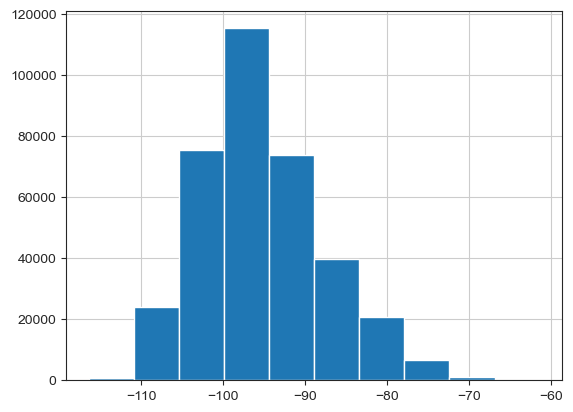

In [819]:
df_3vrl_muts.Energy.hist()

In [820]:
df_3vrl_muts.shape[0]

357279

In [821]:
df_3vrl_muts

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,n_mut,ID,original Slide,Energy org,dEnergy,mut positions
0,SHH16239537_00a_1m_191_00a,HVRQLLLFWYFDVW,True,HVRQLLLFWYF,-103.10,137570-BSDLRDDSLU,1.0,16239537_00a,CVRQLLLFWYF,-106.10,-3.00,[0]
1,SHH16239537_00a_1m_192_00a,KVRQLLLFWYFDVW,True,KVRQLLLFWYF,-100.27,137375-SLSDSRRSDL,1.0,16239537_00a,CVRQLLLFWYF,-106.10,-5.83,[0]
2,SHH16239537_00a_1m_193_00a,MVRQLLLFWYFDVW,True,MVRQLLLFWYF,-106.02,137570-BSDLRDDSLU,1.0,16239537_00a,CVRQLLLFWYF,-106.10,-0.08,[0]
3,SHH16239537_00a_1m_194_00a,PVRQLLLFWYFDVW,True,PVRQLLLFWYF,-101.31,137375-SLSDSRRSDL,1.0,16239537_00a,CVRQLLLFWYF,-106.10,-4.79,[0]
4,SHH16239537_00a_1m_195_00a,QVRQLLLFWYFDVW,False,QVRQLLLFWYF,-92.51,137440-LSDDURRSDL,1.0,16239537_00a,CVRQLLLFWYF,-106.10,-13.59,[0]
...,...,...,...,...,...,...,...,...,...,...,...,...
466502,H_H1527622_03a_3m_37_03a,CANLLWLFWYFKVM,True,LLWLFWYFKVM,-111.92,137442-BRDSLLUDLS,3.0,1527622_03a,LLWLRWYFDVW,-103.72,8.20,"[4, 8, 10]"
466503,H_H1527622_03a_3m_35_03a,CANLLWLFWYFDAM,True,LLWLFWYFDAM,-110.35,137442-BRDSLLUDLS,3.0,1527622_03a,LLWLRWYFDVW,-103.72,6.63,"[4, 9, 10]"
466504,H_H1527622_03a_3m_46_03a,CANLLWLRWHPPVW,True,LLWLRWHPPVW,-97.55,137442-BRDSLLUDLS,3.0,1527622_03a,LLWLRWYFDVW,-103.72,-6.17,"[6, 7, 8]"
466505,H_H1527622_03a_3m_44_03a,CANLLWLRWHFPRW,True,LLWLRWHFPRW,-100.68,137442-BRDSLLUDLS,3.0,1527622_03a,LLWLRWYFDVW,-103.72,-3.04,"[6, 8, 9]"


<AxesSubplot:>

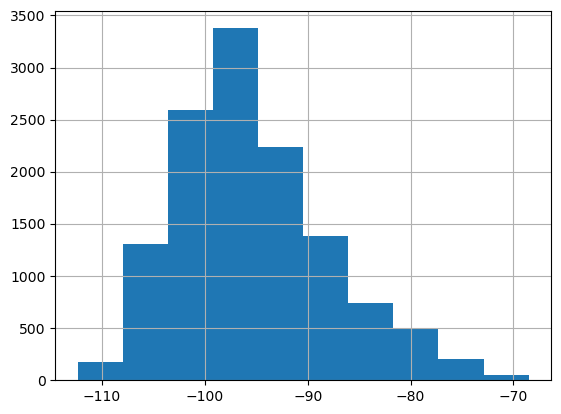

In [326]:
df_3vrl_muts_test = pd.read_csv('./mutant_igs/3VRL_1-3mut_test.csv')
df_3vrl_muts_test.Energy.hist()

In [328]:
df_3vrl_muts_test.shape[0]

12567

In [303]:
non_binder_path = '../data/full_data/divided2classes/3VRL_CAnalyses/3VRL_C_500kNonMascotte.txt'

In [307]:
df_nb_ex = pd.read_csv(non_binder_path, sep='\t', header=1)


<AxesSubplot:>

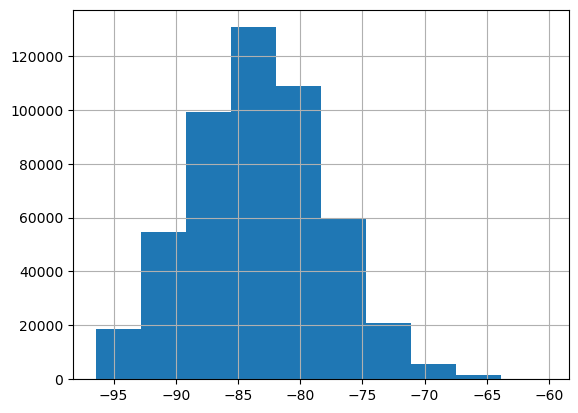

In [309]:
df_nb_ex.Energy.hist()

In [310]:
vs_weak_path = '../data/full_data/divided2classes/3VRL_CAnalyses/3VRL_C_LooserSlices.txt'

In [311]:
df_weak_ex = pd.read_csv(vs_weak_path, sep='\t', header=1)

<AxesSubplot:>

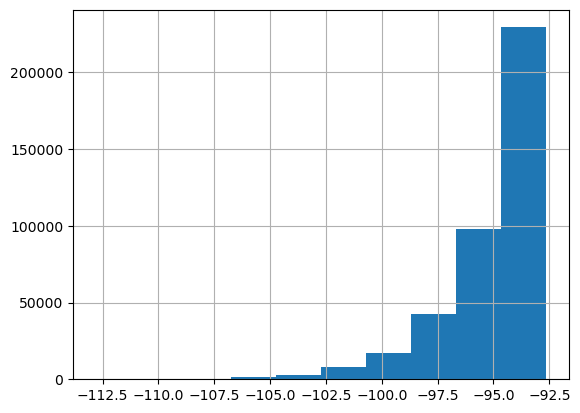

In [313]:
df_weak_ex.Energy.hist()

In [ ]:
# find mutated slides corresponding to slides from test set
def get_org_slide_id(mut_file, wt_path): 
#! think about wt path, right now it is 'vs 9' test. Maybe it should be all binders 'MascotteSlices'
    wt_file = pd.read_csv(wt_path, sep='\t')
    wt_test = wt_file[wt_file['y'] == 1] #then this plave will change
    wt_slides = set(wt_test.Slide)
    int_slides = set(mut_file[mut_file['n_mut'] == 0]['Slide']).intersection(wt_slides)
    slide_id = mut_file[mut_file['Slide'].isin(int_slides) & (mut_file['n_mut']==0)][['Slide', 'ID', 'Energy']]
    return slide_id

In [342]:
wt_path = glob.glob(f'../data/full_data/divided2classes/{ag}_*Analyses/{ag}_*_MascotteSlices.txt')[0]

In [347]:
df_wt_ex = pd.read_csv(wt_path, sep='\t', header=1)

In [348]:
df_wt_ex

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure
0,907_03a,CARCTVVAEGLDYW,True,CTVVAEGLDYW,-90.18,137504-LLURULURSS
1,977_03a,CARHLLGLYWYFDVW,True,HLLGLYWYFDV,-91.32,145764-BSRLULLDLD
2,1860_00a,CARMELGLDYW,True,CARMELGLDYW,-92.34,137504-LLURULURSS
3,2968_00a,CAEGGLGWFAYW,True,CAEGGLGWFAY,-91.73,137504-LSUSURSSSD
4,3227_00a,CARLDWYFDVW,True,CARLDWYFDVW,-94.12,137504-LLURULURSS
...,...,...,...,...,...,...
78121,2057706_05a,CARESIYGYDAGFAYW,True,IYGYDAGFAYW,-93.06,137504-LLURULURSS
78122,2057708_05a,CARESNLLLRWGYFDYW,True,NLLLRWGYFDY,-90.88,145824-RLULLDLRSD
78123,2057827_01a,CARFVSLGHDYW,True,ARFVSLGHDYW,-92.61,149860-DDSSSLUSUS
78124,2057862_04a,CARGALGLRPAMDYW,True,ALGLRPAMDYW,-91.12,145763-BSSRDLDRDL


In [352]:
df_wt_ex.rename(columns={'ID_slide_Variant': 'ID'},inplace=True)

In [350]:
mut_file['ID'] = mut_file['ID_slide_Variant'].apply(find_ids)

In [366]:
df_valid_wt = pd.merge(mut_file, df_wt_ex, on=['Slide'], how='inner')
df_valid_wt.drop_duplicates('Slide', inplace=True)

In [370]:
df_valid_wt.shape[0]

2348

In [377]:
mut_file[mut_file['ID_slide_Variant'] == 'SHH13881484_05a_0m_0_00a']

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,n_mut,ID
0,SHH13881484_05a_0m_0_00a,CASESLITFKPHFDVW,False,CASESLITFKP,-66.38,145760-LURURRDDUS,0.0,13881484_05a


In [378]:
mut_file[mut_file['CDR3'] == 'CASESLITFKPHFDVW']

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,n_mut,ID
0,SHH13881484_05a_0m_0_00a,CASESLITFKPHFDVW,False,CASESLITFKP,-66.38,145760-LURURRDDUS,0.0,13881484_05a
1,SHH13881484_05a_0m_0_01a,CASESLITFKPHFDVW,False,ASESLITFKPH,-69.68,149857-LLDLDSSDDS,0.0,13881484_05a
2,SHH13881484_05a_0m_0_02a,CASESLITFKPHFDVW,False,SESLITFKPHF,-73.76,145764-BSSSRRSUUR,0.0,13881484_05a
3,SHH13881484_05a_0m_0_03a,CASESLITFKPHFDVW,False,ESLITFKPHFD,-78.47,149860-DDSLRDRRUR,0.0,13881484_05a
4,SHH13881484_05a_0m_0_04a,CASESLITFKPHFDVW,False,SLITFKPHFDV,-82.50,145764-BSRLSUULUL,0.0,13881484_05a
5,SHH13881484_05a_0m_0_05a,CASESLITFKPHFDVW,True,LITFKPHFDVW,-99.21,137504-LLURULURSS,0.0,13881484_05a


In [375]:
mut_file[mut_file['CDR3'] == 'AASESLITFEPHFDVW']

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,n_mut,ID
1244,SHH13881484_05a_2m_1_00a,AASESLITFEPHFDVW,False,AASESLITFEP,-65.36,145760-LURURRDDUS,2.0,13881484_05a
1245,SHH13881484_05a_2m_1_01a,AASESLITFEPHFDVW,False,ASESLITFEPH,-69.68,149857-LLDLDSSDDS,2.0,13881484_05a
1246,SHH13881484_05a_2m_1_02a,AASESLITFEPHFDVW,False,SESLITFEPHF,-73.76,145764-BSSSRRSUUR,2.0,13881484_05a
1247,SHH13881484_05a_2m_1_03a,AASESLITFEPHFDVW,False,ESLITFEPHFD,-79.27,149860-DDSLRDRRUR,2.0,13881484_05a
1248,SHH13881484_05a_2m_1_04a,AASESLITFEPHFDVW,True,SLITFEPHFDV,-81.84,145764-BSSURURRSU,2.0,13881484_05a
1249,SHH13881484_05a_2m_1_05a,AASESLITFEPHFDVW,False,LITFEPHFDVW,-80.82,145760-SULLDLRRDR,2.0,13881484_05a


In [371]:
df_wt_ex.head()

,ID,CDR3,Best,Slide,Energy,Structure
0,907_03a,CARCTVVAEGLDYW,True,CTVVAEGLDYW,-90.18,137504-LLURULURSS
1,977_03a,CARHLLGLYWYFDVW,True,HLLGLYWYFDV,-91.32,145764-BSRLULLDLD
2,1860_00a,CARMELGLDYW,True,CARMELGLDYW,-92.34,137504-LLURULURSS
3,2968_00a,CAEGGLGWFAYW,True,CAEGGLGWFAY,-91.73,137504-LSUSURSSSD
4,3227_00a,CARLDWYFDVW,True,CARLDWYFDVW,-94.12,137504-LLURULURSS


In [280]:
"""#for 1-3 mutations
for ag in config.ANTIGENS:
    print(ag)
    slide_id_df = pd.read_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df_full.csv', index_col=0)
    mut_file = prep_mut_df(ag)
    for task in tasks:
        seed_id, split_id = 0, 42 #get_best_model_seed_split(perf_df, task, task, ag, 'acc')
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        model_snn = ml.SNN(10)
        model_snn.linear_1 = model.module.linear_1
        model_snn.linear_2 = model.module.linear_2
        attr = ml.Attributor(model_snn,
            type="deep_lift", 
            baseline_type="shuffle",
            compute_on="logits",
            multiply_by_inputs=False)

        df_mut_attr = mutant_attr(attr,mut_file, slide_id_df, baseline_type ='shuffle', n_mut=[1,2,3])
        df_mut_attr.to_csv(f'./mutant_igs/{ag}_{task}_1-3mut_deelift.csv', index=False)
        break"""
    break

IndentationError: unexpected indent (2658107971.py, line 22)

## New approach

In [397]:
mut_file['ID'] = mut_file['ID_slide_Variant'].apply(find_ids)

0          13881484_05a
1          13881484_05a
2          13881484_05a
3          13881484_05a
4          13881484_05a
               ...     
1393555    12464336_03a
1393556    12464336_03a
1393557    12464336_03a
1393558    12464336_03a
1393559    12464336_03a
Name: ID_slide_Variant, Length: 1393560, dtype: object

In [399]:
mut_file['k-mer var'] = mut_file['ID_slide_Variant'].apply(lambda x: x.split('_')[-1])

In [400]:
mut_file

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,n_mut,ID,k-mer var
0,SHH13881484_05a_0m_0_00a,CASESLITFKPHFDVW,False,CASESLITFKP,-66.38,145760-LURURRDDUS,0.0,13881484_05a,00a
1,SHH13881484_05a_0m_0_01a,CASESLITFKPHFDVW,False,ASESLITFKPH,-69.68,149857-LLDLDSSDDS,0.0,13881484_05a,01a
2,SHH13881484_05a_0m_0_02a,CASESLITFKPHFDVW,False,SESLITFKPHF,-73.76,145764-BSSSRRSUUR,0.0,13881484_05a,02a
3,SHH13881484_05a_0m_0_03a,CASESLITFKPHFDVW,False,ESLITFKPHFD,-78.47,149860-DDSLRDRRUR,0.0,13881484_05a,03a
4,SHH13881484_05a_0m_0_04a,CASESLITFKPHFDVW,False,SLITFKPHFDV,-82.50,145764-BSRLSUULUL,0.0,13881484_05a,04a
...,...,...,...,...,...,...,...,...,...
1393555,H_H12464336_03a_3m_43_04a,CASFYYYGSSLDYWYFDVM,True,YYYGSSLDYWY,-76.43,145760-SULULLSUDS,3.0,12464336_03a,04a
1393556,H_H12464336_03a_3m_43_05a,CASFYYYGSSLDYWYFDVM,False,YYGSSLDYWYF,-74.38,145762-SLULLRRUUL,3.0,12464336_03a,05a
1393557,H_H12464336_03a_3m_43_06a,CASFYYYGSSLDYWYFDVM,False,YGSSLDYWYFD,-75.52,149857-LRDDSRRSSS,3.0,12464336_03a,06a
1393558,H_H12464336_03a_3m_43_07a,CASFYYYGSSLDYWYFDVM,False,GSSLDYWYFDV,-66.75,149857-LRDURRSSRR,3.0,12464336_03a,07a


In [417]:
df_0mut = mut_file[mut_file['n_mut'] == 0]
df_mut = mut_file[mut_file['n_mut'] != 0]
df_mut = pd.merge(df_mut, df_0mut, on=['ID', 'k-mer var'], how='left', suffixes=('_mut', '_wt'))
df_mut.
#maybe here check that Energy_wt is in binder range


In [418]:
df_mut = df_mut[df_mut['Slide_mut'] != df_mut['Slide_wt']]

In [419]:
df_mut.shape[0]

1193430

In [420]:
df_mut['dEnergy'] = df_mut['Energy_wt'] - df_mut['Energy_mut']

In [422]:
df_mut[df_mut['dEnergy']==0]

,ID_slide_Variant_mut,CDR3_mut,Best_mut,Slide_mut,Energy_mut,Structure_mut,n_mut_mut,ID,k-mer var,ID_slide_Variant_wt,CDR3_wt,Best_wt,Slide_wt,Energy_wt,Structure_wt,n_mut_wt,dEnergy
91,SHH13881484_05a_1m_16_01a,CASEALITFKPHFDVW,False,ASEALITFKPH,-69.68,149857-LLDLDSSDDS,1.0,13881484_05a,01a,SHH13881484_05a_0m_0_01a,CASESLITFKPHFDVW,False,ASESLITFKPH,-69.68,149857-LLDLDSSDDS,0.0,0.0
97,SHH13881484_05a_1m_17_01a,CASEELITFKPHFDVW,False,ASEELITFKPH,-69.68,149857-LLDLDSSDDS,1.0,13881484_05a,01a,SHH13881484_05a_0m_0_01a,CASESLITFKPHFDVW,False,ASESLITFKPH,-69.68,149857-LLDLDSSDDS,0.0,0.0
109,SHH13881484_05a_1m_19_01a,CASEGLITFKPHFDVW,False,ASEGLITFKPH,-69.68,149857-LLDLDSSDDS,1.0,13881484_05a,01a,SHH13881484_05a_0m_0_01a,CASESLITFKPHFDVW,False,ASESLITFKPH,-69.68,149857-LLDLDSSDDS,0.0,0.0
133,SHH13881484_05a_1m_23_01a,CASEPLITFKPHFDVW,False,ASEPLITFKPH,-69.68,149857-LLDLDSSDDS,1.0,13881484_05a,01a,SHH13881484_05a_0m_0_01a,CASESLITFKPHFDVW,False,ASESLITFKPH,-69.68,149857-LLDLDSSDDS,0.0,0.0
145,SHH13881484_05a_1m_25_01a,CASERLITFKPHFDVW,False,ASERLITFKPH,-69.68,149857-LLDLDSSDDS,1.0,13881484_05a,01a,SHH13881484_05a_0m_0_01a,CASESLITFKPHFDVW,False,ASESLITFKPH,-69.68,149857-LLDLDSSDDS,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390883,H_H12464336_03a_3m_42_04a,CASFYYYGSSLDYWYFDNA,True,YYYGSSLDYWY,-76.43,145760-SULULLSUDS,3.0,12464336_03a,04a,H_H12464336_03a_0m_0_04a,CASFYYYGSSLGYWYFDVW,False,YYYGSSLGYWY,-76.43,145760-SULULLSUDS,0.0,0.0
1390885,H_H12464336_03a_3m_42_06a,CASFYYYGSSLDYWYFDNA,False,YGSSLDYWYFD,-75.52,149857-LRDDSRRSSS,3.0,12464336_03a,06a,H_H12464336_03a_0m_0_06a,CASFYYYGSSLGYWYFDVW,False,YGSSLGYWYFD,-75.52,149857-LRDDSRRSSS,0.0,0.0
1390890,H_H12464336_03a_3m_43_02a,CASFYYYGSSLDYWYFDVM,False,SFYYYGSSLDY,-75.49,145764-BSSURURRSU,3.0,12464336_03a,02a,H_H12464336_03a_0m_0_02a,CASFYYYGSSLGYWYFDVW,False,SFYYYGSSLGY,-75.49,145764-BSSURURRSU,0.0,0.0
1390892,H_H12464336_03a_3m_43_04a,CASFYYYGSSLDYWYFDVM,True,YYYGSSLDYWY,-76.43,145760-SULULLSUDS,3.0,12464336_03a,04a,H_H12464336_03a_0m_0_04a,CASFYYYGSSLGYWYFDVW,False,YYYGSSLGYWY,-76.43,145760-SULULLSUDS,0.0,0.0


In [ ]:
df_mut['n_mut_slide'] = df_mut.apply(lambda x: x.Slide_mut, x.Slide_wt)

<AxesSubplot:>

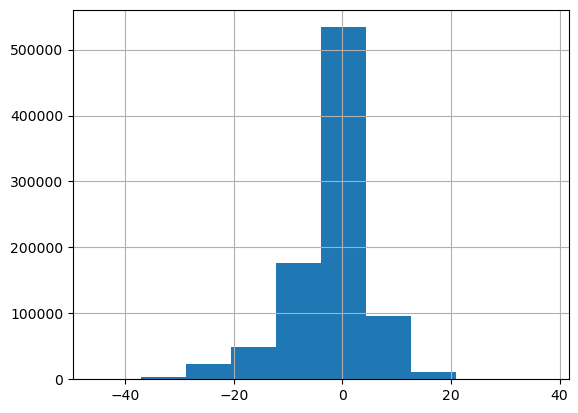

In [424]:
df_mut['dEnergy'].hist()

In [462]:
df_mut[df_mut.Slide_wt.isnull()]

,ID_slide_Variant_mut,CDR3_mut,Best_mut,Slide_mut,Energy_mut,Structure_mut,n_mut_mut,ID,k-mer var,ID_slide_Variant_wt,CDR3_wt,Best_wt,Slide_wt,Energy_wt,Structure_wt,n_mut_wt,dEnergy,wt is binder
152,SHH13881484_05a_1m_26_01b,CASESAITFKPHFDVW,False,ASESAITFKPH,-60.580,145760-LURURDSRRS,1.0,13881484_05a,01b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
154,SHH13881484_05a_1m_26_02b,CASESAITFKPHFDVW,False,SESAITFKPHF,-79.320,149924-RDRSSSDDRD,1.0,13881484_05a,02b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
155,SHH13881484_05a_1m_26_02c,CASESAITFKPHFDVW,False,SESAITFKPHF,-79.320,153956-DSDSSSLLDL,1.0,13881484_05a,02c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
186,SHH13881484_05a_1m_31_02b,CASESLDTFKPHFDVW,False,SESLDTFKPHF,-78.550,149924-RDRSSSDDRD,1.0,13881484_05a,02b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
187,SHH13881484_05a_1m_31_02c,CASESLDTFKPHFDVW,False,SESLDTFKPHF,-78.550,153956-DSDSSSLLDL,1.0,13881484_05a,02c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389982,H_H12464336_03a_1m_195_00c,KASFYYYGSSLGYWYFDVW,False,KASFYYYGSSL,-81.730,153956-DSDSSDLLUL,1.0,12464336_03a,00c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1390119,H_H12464336_03a_2m_9_02b,CASEYYYGWSLGYWYFDVW,False,SEYYYGWSLGY,-73.550,149920-DRURUULUDS,2.0,12464336_03a,02b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1390347,H_H12464336_03a_3m_13_04b,CASFYEYGSGDGYWYFDVW,False,YEYGSGDGYWY,-68.570,145764-BSRLUDDLDL,3.0,12464336_03a,04b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1390414,H_H12464336_03a_2m_21_07b,CASFYKYGSSLGYDYFDVW,False,GSSLGYDYFDV,-70.705,149921-RDRDDSDUSR,2.0,12464336_03a,07b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [464]:
df_mut.dropna(axis=0, inplace=True) # i need to figure out why I have so many nans

In [426]:
eng_cut_off = df_wt_ex.Energy.max()

In [427]:
df_mut['wt is binder'] = df_mut['Energy_wt'].apply(lambda x: x <= eng_cut_off)

In [430]:
df_mut['wt is binder'].value_counts()

False    1078852
True      114578
Name: wt is binder, dtype: int64

In [431]:
df_mut['Energy_mut'].apply(lambda x: x <= eng_cut_off).value_counts()

False    1129022
True       64408
Name: Energy_mut, dtype: int64

In [463]:
ag

'1NSN'

In [468]:
df_mut.Slide_mut.apply(list)
df_mut.Slide_wt.apply(list)

0          False
6          False
7          False
8          False
12         False
           ...  
1390892    False
1390893    False
1390894    False
1390895    False
1390896    False
Length: 790909, dtype: bool

In [471]:
df_mut.Slide_mut.apply(list)


0          [A, A, S, E, S, L, I, T, F, K, P]
6          [C, A, A, E, S, L, I, T, F, K, P]
7          [A, A, E, S, L, I, T, F, K, P, H]
8          [A, E, S, L, I, T, F, K, P, H, F]
12         [C, A, C, E, S, L, I, T, F, K, P]
                         ...                
1390892    [Y, Y, Y, G, S, S, L, D, Y, W, Y]
1390893    [Y, Y, G, S, S, L, D, Y, W, Y, F]
1390894    [Y, G, S, S, L, D, Y, W, Y, F, D]
1390895    [G, S, S, L, D, Y, W, Y, F, D, V]
1390896    [S, S, L, D, Y, W, Y, F, D, V, M]
Name: Slide_mut, Length: 790909, dtype: object

In [484]:
df_mut.apply(lambda x: (i==j for i, j in list(zip(list(x.Slide_mut), list(x.Slide_wt)))), axis=1) #need to append into a list

0          <generator object <lambda>.<locals>.<genexpr> ...
6          <generator object <lambda>.<locals>.<genexpr> ...
7          <generator object <lambda>.<locals>.<genexpr> ...
8          <generator object <lambda>.<locals>.<genexpr> ...
12         <generator object <lambda>.<locals>.<genexpr> ...
                                 ...                        
1390892    <generator object <lambda>.<locals>.<genexpr> ...
1390893    <generator object <lambda>.<locals>.<genexpr> ...
1390894    <generator object <lambda>.<locals>.<genexpr> ...
1390895    <generator object <lambda>.<locals>.<genexpr> ...
1390896    <generator object <lambda>.<locals>.<genexpr> ...
Length: 790909, dtype: object

In [477]:
for i, j in zip(['a', 'a'], ['b', 'b']):
    print(i,j)

a b
a b


## Let's go from 0

In [497]:
ag = '1NSN'
mut_file = prep_mut_df(ag)


In [498]:
mut_file.drop_duplicates('Slide', inplace=True)

In [488]:
1393560/880749

1.582244203513146

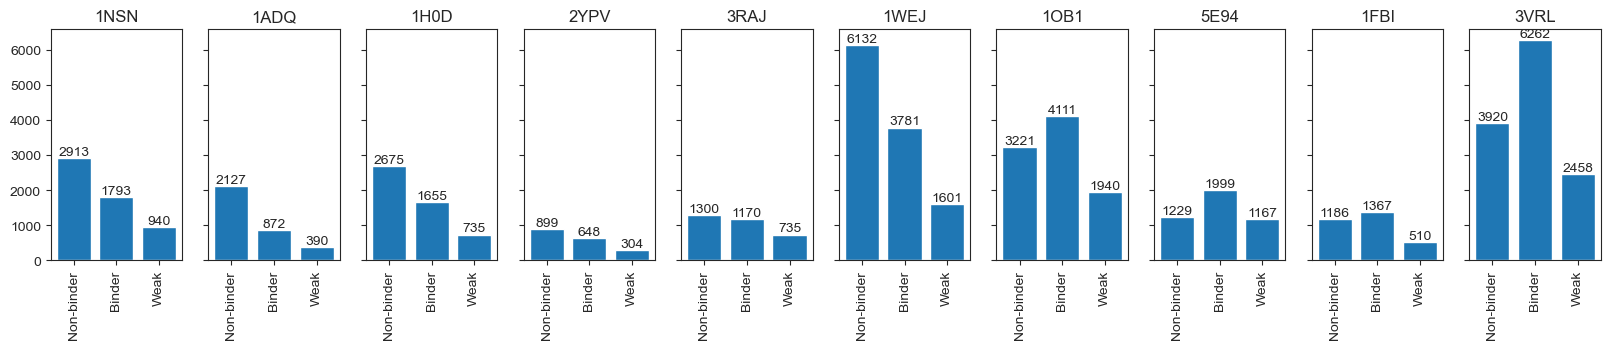

In [824]:
#what if I annotate only those that I've been working with so far?
#let's first join them
fig, ax = plt.subplots(ncols =10, figsize = (20,3), sharey=True, sharex=True)
for i,ag in enumerate(ag_order):
    pd_mut = pd.read_csv(f'./mutant_igs/{ag}_{task}_1-3mut_igs.csv')
    binder_max_eng, non_binder_min_eng = get_binding_class_energies(ag)
    pd_mut['binding class'] = pd_mut.Energy.apply(lambda x: get_binding_class(x, binder_max_eng, non_binder_min_eng))
    pd_class_counts = pd_mut['binding class'].value_counts()
    ax[i].bar(pd_class_counts.index, pd_class_counts.values, )
    ax[i].tick_params(axis='x', labelrotation=90)
    ax[i].set_title(f'{ag}')
    
    ax[i].text(1, pd_class_counts['Binder'] + 0.5, str(pd_class_counts['Binder']), ha='center', va='bottom')
    ax[i].text(0, pd_class_counts['Non-binder'] + 0.5, str(pd_class_counts['Non-binder']), ha='center', va='bottom')
    ax[i].text(2, pd_class_counts['Weak'] + 0.5, str(pd_class_counts['Weak']), ha='center', va='bottom')


<AxesSubplot:>

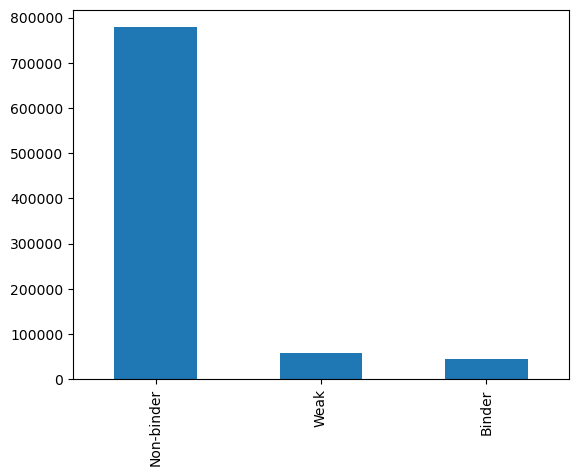

In [513]:
mut_file['binding class'].value_counts().plot.bar()

In [515]:
mut_file[mut_file['binding class'] == 'Weak'].n_mut.value_counts()

1.0    23846
2.0    10166
3.0     9336
0.0      122
Name: n_mut, dtype: int64

In [555]:
ag_order = ['1NSN', '1ADQ', '1H0D', '2YPV', '3RAJ', '1WEJ', '1OB1', '5E94', '1FBI', '3VRL']

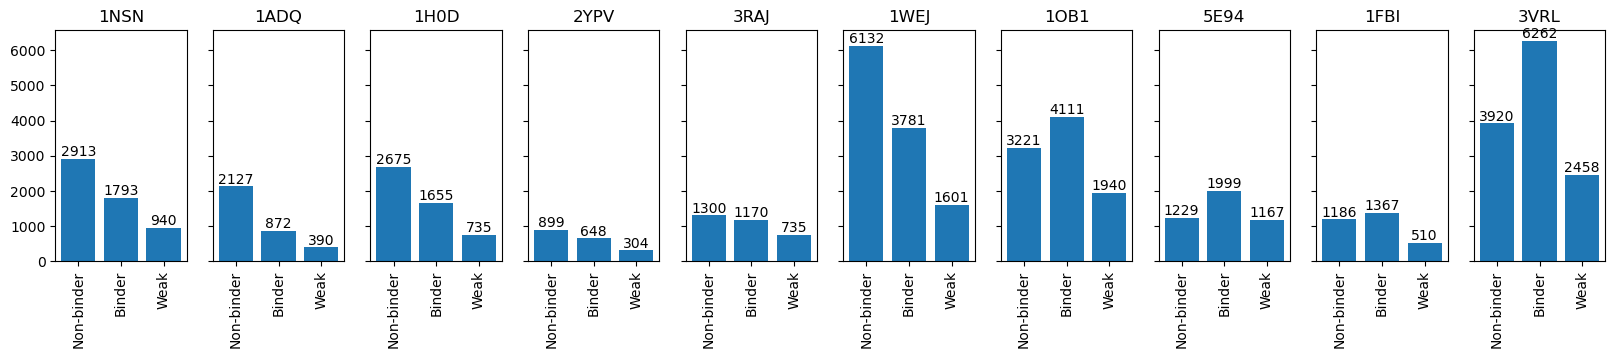

In [644]:
#compare order to deltaLogits, deltaEnergy to logit Energy (only vs 9)
logit_energy_corr_path = "../data/07e_LogitEnergyCorrelations.tsv"
df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")
df_logits_old = pd.read_csv("../data/07e_LogitEnergyCorrelations_old.tsv", sep="\t")
df_logits_new = pd.concat(
    [
        df_logits.query("task_type == '1v1'").copy(),
        df_logits_old.query("task_type != '1v1'").copy(),
    ],
    axis=0
)
df_logits_new.task_type.value_counts()
df_logits = df_logits_new.copy()

def get_logit_energy_corr_order(task):
    task = tasks_dict[task]
    order = df_logits[df_logits['task_type'] == task].groupby(['task_type', 'ag_pos']).mean().sort_values('r', ascending=False).index
    order = list(map(lambda x: x[1], order))
    return order

In [645]:
#now we need to get delta orders
def get_dlogit_denergy_corr_order_mut(task):
    order = []
    for ag in config.ANTIGENS:
        pd_1_mut = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        pd_23_mut = pd.read_csv(f'./mutant_igs/{ag}_{task}_2-3mut_igs.csv')
        pd_mut = pd.concat([pd_1_mut,pd_23_mut], axis=0)
        r = np.corrcoef(pd_mut['dLogits'].values, pd_mut['dEnergy'].values)[0,1]
        order.append((ag,r))
    order = sorted(order, key=lambda x: x[1], reverse=True)
    order = list(map(lambda x: x[0], order))
    return order


In [599]:
from scipy.stats import kendalltau

In [661]:
ktau_mut_wt_logit = dict()
for task in tasks:
    logit_order = get_logit_energy_corr_order(task)
    mut_logit_order = get_dlogit_denergy_corr_order_mut(task)
    tau, p = kendalltau(logit_order, mut_logit_order)
    ktau_mut_wt_logit[task] = tau

In [662]:
ktau_mut_wt_logit

{'ONE_VS_NINE': 0.15555555555555553,
 'HIGH_VS_95LOW': 0.4222222222222222,
 'HIGH_VS_LOOSER': 0.06666666666666667}

In [625]:
ktau_mut_wt_logit

{'ONE_VS_NINE': 0.15555555555555553,
 'HIGH_VS_95LOW': 0.4222222222222222,
 'HIGH_VS_LOOSER': 0.06666666666666667}

In [670]:
import scipy.stats

In [673]:
spr_mut_wt_logit = dict()
for task in tasks:
    logit_order = get_logit_energy_corr_order(task)
    mut_logit_order = get_dlogit_denergy_corr_order_mut(task)
    ro, p = scipy.stats.spearmanr(logit_order, mut_logit_order)
    spr_mut_wt_logit[task] = ro

In [674]:
spr_mut_wt_logit

{'ONE_VS_NINE': 0.12727272727272726,
 'HIGH_VS_95LOW': 0.6,
 'HIGH_VS_LOOSER': 0.13939393939393938}

In [682]:
"""mps_device = torch.device("mps")
for ag in tqdm(config.ANTIGENS, desc='Antigens'):
    for task in tasks:
        pd_1_mut = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        pd_23_mut = pd.read_csv(f'./mutant_igs/{ag}_{task}_2-3mut_igs.csv')
        pd_mut = pd.concat([pd_1_mut,pd_23_mut], axis=0)
        pd_mut['org OH'] = pd_mut['original Slide'].apply(lambda x: [[onehot_encode(x)]])
        pd_mut['mut OH'] = pd_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
        seed_id, split_id = 0, 42
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device("cpu"))

        X_org = torch.tensor(pd_mut['org OH'].tolist(), dtype=torch.float32).to("cpu")
        X_mut = torch.tensor(pd_mut['mut OH'].tolist(), dtype=torch.float32).to("cpu")
        y_pred_org, logits_org = model(X_org, return_logits = True)
        y_pred_mut, logits_mut = model(X_mut, return_logits = True)

        pd_mut['mut Logits'] = logits_mut.cpu().detach().numpy().reshape(-1)
        pd_mut['pred y'] = y_pred_mut.cpu().detach().numpy().reshape(-1)

        binder_max_eng, non_binder_min_eng = get_binding_class_energies(ag)
        pd_mut['true binding class'] = pd_mut.Energy.apply(lambda x: get_binding_class(x, binder_max_eng, non_binder_min_eng))
        pd_mut['true y'] = pd_mut['true binding class'].apply(lambda x: True if x=='Binder' else False)

        pd_mut.to_csv(f'./mutant_igs/{ag}_{task}_1-3mut_igs.csv', index=False)"""

Antigens: 100%|██████████| 10/10 [03:35<00:00, 21.60s/it]


In [700]:
task = 'ONE_VS_NINE'
order_dict = dict()
for j, ag in enumerate(config.ANTIGENS): 
    df_a = pd.read_csv(f'./mutant_igs/{ag}_{task}_1-3mut_igs.csv')
    order_dict[ag] = np.corrcoef(df_a['dLogits'].values, df_a['dEnergy'].values)[0,1]
#order dict by values
order_dict = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1], reverse=True)}

In [733]:
task_template[task].format(ag=ag)

'1NSN_high__vs__1NSN_95low'

In [858]:
from Bio import motifs
from Bio.Seq import Seq
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

def get_pwm(slides_1, slides_2):
    # Create a list of Seq objects
    seqs_1 = [Seq(slide) for slide in slides_1]
    seqs_2 = [Seq(slide) for slide in slides_2]

    # Create a motifs instance
    m_1 = motifs.create(seqs_1, alphabet=config.AMINOACID_ALPHABET) # type: ignore
    m_2 = motifs.create(seqs_2, alphabet=config.AMINOACID_ALPHABET) # type: ignore

    # Get the position weight matrix
    pwm_1: np.ndarray = pd.DataFrame(m_1.pwm).values
    pwm_1 += 1e-20  # Avoid log(0)
    pwm_2: np.ndarray = pd.DataFrame(m_2.pwm).values
    pwm_2 += 1e-20  # Avoid log(0)
    return pwm_1, pwm_2

def jensen_shannon_divergence_slides(slides_1, slides_2):

    pwm_1, pwm_2 = get_pwm(slides_1, slides_2)
    return jensenshannon(pwm_1, pwm_2, axis=1, base=2).sum() 

In [852]:
tasks

['ONE_VS_NINE', 'HIGH_VS_95LOW', 'HIGH_VS_LOOSER']

In [900]:
ag_jsd_wt_mut = dict()
for j, ag in enumerate(config.ANTIGENS):
    #open some test datasets choose split and seed the same as was used for mutants filtering
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0]
    df_wt = pd.read_csv(wt_path, sep='\t')
    wt_binder = df_wt[df_wt['y'] == 1]['Slide'].values
    mut_ig = pd.read_csv(f'./mutant_igs/{ag}_1-3mut.csv')
    mut_slides_weak = mut_ig[mut_ig['binding class'] == 'Weak']['Slide'].values
    mut_slides_binder = mut_ig[mut_ig['binding class'] == 'Binder']['Slide'].values
    mut_slides_nonbinder = mut_ig[mut_ig['binding class'] == 'Non-binder']['Slide'].values
    jsd_b_mw= jensen_shannon_divergence_slides(wt_binder, mut_slides_weak)
    jsd_b_mb = jensen_shannon_divergence_slides(wt_binder, mut_slides_binder)
    jsd_b_mnb = jensen_shannon_divergence_slides(wt_binder, mut_slides_nonbinder)
    jsd_mb_mw = jensen_shannon_divergence_slides(mut_slides_binder, mut_slides_weak)
    jsd_mb_mnb = jensen_shannon_divergence_slides(mut_slides_binder, mut_slides_nonbinder)
    ag_jsd_wt_mut[ag] = {"wtBinder vs mutWeak":jsd_b_mw,
                         "wtBinder vs mutBinder":jsd_b_mb,
                         "wtBinder vs mutNonbinder":jsd_b_mnb,
                         "mutBinder vs mutWeak": jsd_mb_mw,
                         "mutBinder vs mutNonbinder": jsd_mb_mnb}
    for i, task in enumerate(tasks):
        #compare binder to wt negative classes
        #compare wt negative classes to mut negative classes
        wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_0/split_0/{task_template[task].format(ag=ag)}/*_test_dataset.tsv')[0]
        df_wt = pd.read_csv(wt_path, sep='\t')
        slides_neg = df_wt[df_wt['y'] == 0]['Slide'].values
        jsd_b_neg= jensen_shannon_divergence_slides(wt_binder,  slides_neg)
        if task == 'HIGH_VS_95LOW':
            jsd_wtnb_mutnb = jensen_shannon_divergence_slides(slides_neg, mut_slides_nonbinder)
            ag_jsd_wt_mut[ag].update({"wtNonbinder vs mutNonbinder":jsd_wtnb_mutnb, "wtBinder vs wtNonbinder":jsd_b_neg})
        elif task == 'HIGH_VS_LOOSER':
            jsd_wtweak_mutweak = jensen_shannon_divergence_slides(slides_neg,  mut_slides_weak)
            ag_jsd_wt_mut[ag].update({"wtWeak vs mutWeak":jsd_wtweak_mutweak, "wtBinder vs wtWeak":jsd_b_neg})
        else:
            ag_jsd_wt_mut[ag].update({ "wtBinder vs wtvs9":jsd_b_neg})

In [901]:
df_jsds_wt_mut = pd.DataFrame(ag_jsd_wt_mut)
df_jsds_wt_mut.reset_index(inplace=True)
df_jsds_wt_mut.rename(columns={"index": "datasets"}, inplace=True)
df_jsds_wt_mut = pd.melt(df_jsds_wt_mut, id_vars=['datasets'], var_name='ag', value_name='jsd')

In [1011]:
order = ['wtBinder vs wtWeak',  'wtBinder vs mutWeak', 'mutBinder vs mutWeak', 'wtWeak vs mutWeak',
 'wtBinder vs wtNonbinder', 'wtBinder vs mutNonbinder',  'mutBinder vs mutNonbinder', 'wtNonbinder vs mutNonbinder',
 'wtBinder vs mutBinder', 'wtBinder vs wtvs9']

[]

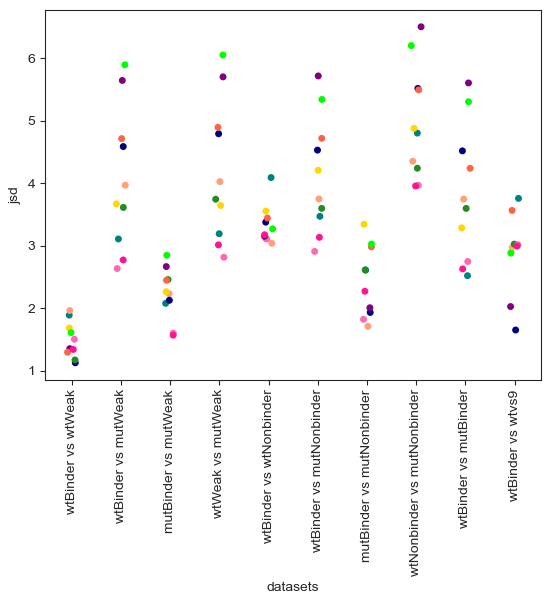

In [1012]:
sns.stripplot(df_jsds_wt_mut, x='datasets',y='jsd', hue='ag', palette=['#008080','#FFA07A','#000080','#FFD700','#228B22','#FF69B4','#800080','#FF6347','#00FF00','#FF1493'], order=order, legend=False)
plt.xticks(rotation=90)
plt.plot()
#plt.legend(loc='lower center',  ncol=4)
#maube it makes sense to add here also mutBinder and mutWeak, mutBimder and mutNonbinder
#that will make much more sense

In [1029]:
from scipy.stats import entropy
def entropy_slides(slides):

    # Create a list of Seq objects
    seqs = [Seq(slide) for slide in slides]

    # Create a motifs instance
    m = motifs.create(seqs, alphabet=config.AMINOACID_ALPHABET) # type: ignore

    # Get the position weight matrix
    pwm: np.ndarray = pd.DataFrame(m.pwm).values

    pwm += 1e-20  # Avoid log(0)

    # Compute entropy of a position-weight matrix
    return entropy(pwm, axis=1, base=2).sum()

In [1016]:
ag_wt_mut_prop = dict()
for j, ag in enumerate(config.ANTIGENS):
    #open some test datasets choose split and seed the same as was used for mutants filtering
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0]
    df_wt = pd.read_csv(wt_path, sep='\t')
    wt_binder = len(df_wt[df_wt['y'] == 1]['Slide'].values)
    mut_ig = pd.read_csv(f'./mutant_igs/{ag}_1-3mut.csv')
    mut_slides_weak = len(mut_ig[mut_ig['binding class'] == 'Weak']['Slide'].values)
    mut_slides_binder = len(mut_ig[mut_ig['binding class'] == 'Binder']['Slide'].values)
    mut_slides_nonbinder = len(mut_ig[mut_ig['binding class'] == 'Non-binder']['Slide'].values)
    ag_wt_mut_prop[ag] = {"wtBinder vs mutWeak":wt_binder/mut_slides_weak,
                         "wtBinder vs mutBinder":wt_binder/mut_slides_binder,
                         "wtBinder vs mutNonbinder":wt_binder/mut_slides_nonbinder,
                         "mutBinder vs mutWeak": mut_slides_binder/mut_slides_weak,
                         "mutBinder vs mutNonbinder": mut_slides_binder/mut_slides_nonbinder}
    for i, task in enumerate(tasks):
        #compare binder to wt negative classes
        #compare wt negative classes to mut negative classes
        wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_0/split_0/{task_template[task].format(ag=ag)}/*_test_dataset.tsv')[0]
        df_wt = pd.read_csv(wt_path, sep='\t')
        slides_neg = len(df_wt[df_wt['y'] == 0]['Slide'].values)
        if task == 'HIGH_VS_95LOW':
            ag_wt_mut_prop[ag].update({"wtNonbinder vs mutNonbinder":slides_neg/mut_slides_nonbinder, "wtBinder vs wtNonbinder":wt_binder/slides_neg})
        elif task == 'HIGH_VS_LOOSER':
   
            ag_wt_mut_prop[ag].update({"wtWeak vs mutWeak":slides_neg/mut_slides_weak, "wtBinder vs wtWeak":wt_binder/slides_neg})
        else:
            ag_wt_mut_prop[ag].update({ "wtBinder vs wtvs9":wt_binder/slides_neg})


In [1052]:
df_wt_mut_prop = pd.DataFrame(ag_wt_mut_prop)
df_wt_mut_prop.reset_index(inplace=True)
df_wt_mut_prop.rename(columns={"index": "datasets"}, inplace=True)
df_wt_mut_prop = pd.melt(df_wt_mut_prop, id_vars=['datasets'], var_name='ag', value_name='size propotion')

In [1053]:
df_wt_mut_prop = df_wt_mut_prop.groupby('datasets').median().loc[order]


In [1034]:
ag_wt_mut_ent_prop = dict()
for j, ag in enumerate(config.ANTIGENS):
    #open some test datasets choose split and seed the same as was used for mutants filtering
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0]
    df_wt = pd.read_csv(wt_path, sep='\t')
    wt_binder = entropy_slides(df_wt[df_wt['y'] == 1]['Slide'].values)
    mut_ig = pd.read_csv(f'./mutant_igs/{ag}_1-3mut.csv')
    mut_slides_weak = entropy_slides(mut_ig[mut_ig['binding class'] == 'Weak']['Slide'].values)
    mut_slides_binder = entropy_slides(mut_ig[mut_ig['binding class'] == 'Binder']['Slide'].values)
    mut_slides_nonbinder = entropy_slides(mut_ig[mut_ig['binding class'] == 'Non-binder']['Slide'].values)
    ag_wt_mut_ent_prop[ag] = {"wtBinder vs mutWeak":wt_binder/mut_slides_weak,
                         "wtBinder vs mutBinder":wt_binder/mut_slides_binder,
                         "wtBinder vs mutNonbinder":wt_binder/mut_slides_nonbinder,
                         "mutBinder vs mutWeak": mut_slides_binder/mut_slides_weak,
                         "mutBinder vs mutNonbinder": mut_slides_binder/mut_slides_nonbinder}
    for i, task in enumerate(tasks):
        #compare binder to wt negative classes
        #compare wt negative classes to mut negative classes
        wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_0/split_0/{task_template[task].format(ag=ag)}/*_test_dataset.tsv')[0]
        df_wt = pd.read_csv(wt_path, sep='\t')
        slides_neg = entropy_slides(df_wt[df_wt['y'] == 0]['Slide'].values)
        if task == 'HIGH_VS_95LOW':
            ag_wt_mut_ent_prop[ag].update({"wtNonbinder vs mutNonbinder":slides_neg/mut_slides_nonbinder, "wtBinder vs wtNonbinder":wt_binder/slides_neg})
        elif task == 'HIGH_VS_LOOSER':
            ag_wt_mut_ent_prop[ag].update({"wtWeak vs mutWeak":slides_neg/mut_slides_weak, "wtBinder vs wtWeak":wt_binder/slides_neg})
        else:
            ag_wt_mut_ent_prop[ag].update({ "wtBinder vs wtvs9":wt_binder/slides_neg})


In [1042]:
df_wt_mut_ent_prop = pd.DataFrame(ag_wt_mut_ent_prop)
df_wt_mut_ent_prop.reset_index(inplace=True)
df_wt_mut_ent_prop.rename(columns={"index": "datasets"}, inplace=True)
df_wt_mut_ent_prop = pd.melt(df_wt_mut_ent_prop, id_vars=['datasets'], var_name='ag', value_name='internal entropies proportion')

In [1069]:
#pd.join([df_wt_mut_ent_prop.groupby('datasets').median().loc[order], df_wt_mut_prop.groupby('datasets').median().loc[order]])
df_wt_mut_ent_prop = df_wt_mut_ent_prop.groupby('datasets').median().loc[order]

In [1070]:
df_wt_mut_ent_prop['internal entropies proportion']

datasets
wtBinder vs wtWeak             0.934168
wtBinder vs mutWeak            1.047589
mutBinder vs mutWeak           0.966013
wtWeak vs mutWeak              1.109621
wtBinder vs wtNonbinder        0.917808
wtBinder vs mutNonbinder       1.012949
mutBinder vs mutNonbinder      0.934019
wtNonbinder vs mutNonbinder    1.083497
wtBinder vs mutBinder          1.091084
wtBinder vs wtvs9              0.927106
Name: internal entropies proportion, dtype: float64

In [1071]:
df_wt_mut_prop['internal entropies proportion'] = df_wt_mut_ent_prop['internal entropies proportion']

In [1072]:
df_wt_mut_prop


,size propotion,internal entropies proportion
datasets,,
wtBinder vs wtWeak,1.000000,0.934168
wtBinder vs mutWeak,6.046058,1.047589
mutBinder vs mutWeak,2.286569,0.966013
wtWeak vs mutWeak,6.046058,1.109621
wtBinder vs wtNonbinder,1.000000,0.917808
wtBinder vs mutNonbinder,2.177253,1.012949
mutBinder vs mutNonbinder,0.860944,0.934019
wtNonbinder vs mutNonbinder,2.177253,1.083497
wtBinder vs mutBinder,2.797490,1.091084


In [ ]:
# this is likely because mutants are originated just from few wt sequences 
# looking to dlogits and d \energy correlation doesn't give any new information

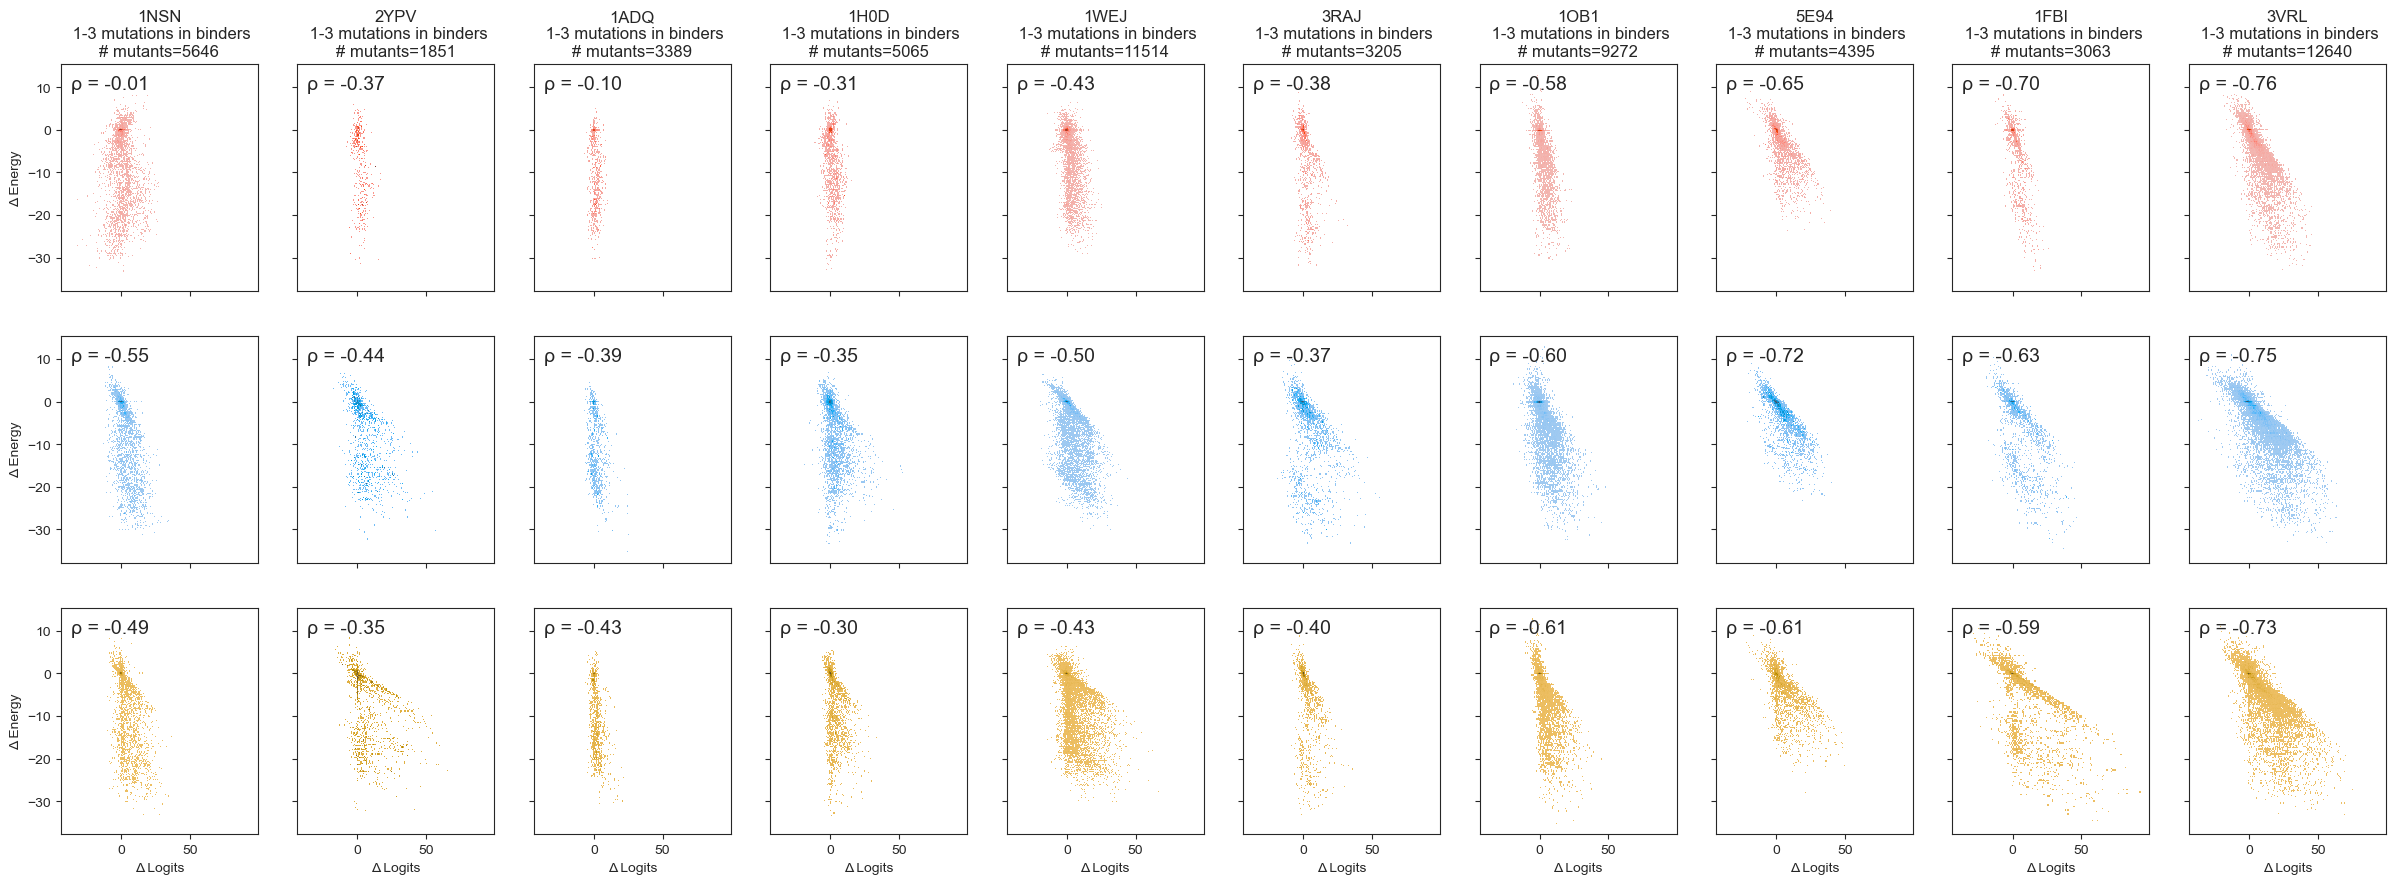

In [1009]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_1-3mut_igs.csv')
        color = get_color(task)
        sns.histplot(mut_ig, x = 'dLogits', y='dEnergy',color=color, ax=ax[i,j], bins=150)
        r = np.corrcoef(mut_ig['dLogits'].values, mut_ig['dEnergy'].values)[0,1]
        n = len(mut_ig)
        #acc = (mut_ig['true y'].apply(round) == mut_ig['pred y'].apply(round)).value_counts()[True]/n
        #acc = round(acc,2)
        #test_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_0/split_0/{task_template[task].format(ag=ag)}/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
        #df_test = pd.read_csv(test_path, sep='\t')
        #test_slides_neg = df_test[df_test['y'] == 0]['Slide']
        #test_slides_pos = df_test[df_test['y'] == 1]['Slide']
        #jsd_neg = jensen_shannon_divergence_slides(mut_ig['Slide'], test_slides_neg)
        #jsd_pos = jensen_shannon_divergence_slides(mut_ig['Slide'], test_slides_pos)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}'.format(r), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ Logits')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(f'{ag}\n 1-3 mutations in binders\n# mutants={n}')

In [909]:
#let's calculate attributions for mutants:) in parallel

def swa_model_to_snn(model_path):
    model = torch.load(model_path)
    model_snn = ml.SNN(10)
    model_snn.linear_1 = model.module.linear_1
    model_snn.linear_2 = model.module.linear_2
    return model_snn

In [ ]:
#for 1-3 mutations
for ag in config.ANTIGENS:
    df_mut = pd.read_csv(f'./mutant_igs/{ag}_1-3mut.csv')
    wt_slides = df_mut['original Slide'].unique()
    for task in tasks:
        seed_id, split_id = 0, 0
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model_snn = swa_model_to_snn(model_path)
        model_snn.to('cpu')
        attr = ml.Attributor(model_snn,
            type="deep_lift", 
            baseline_type="shuffle",
            compute_on="logits",
            multiply_by_inputs=False)

        df_mut_attr = mutant_df_attr(df_mut, attr, 'shuffle')
        df_mut_attr.to_csv(f'./mutant_igs/{ag}_{task}_1-3mut_deelift.csv', index=False)


In [ ]:
for j, ag in enumerate(config.ANTIGENS):
    for i, task in enumerate(tasks):
        df_mut_attr = pd.read_csv(f'./mutant_igs/{ag}_{task}_1-3mut_deelift.csv')
        df_mut_attr['attr mut'] = df_mut_attr['attr mut'].apply(lambda x: np.array(eval(x)))
        df_mut_attr['attr wt']= df_mut_attr['attr wt'].apply(lambda x: np.array(eval(x)))
        df_mut_attr['delta attr'] = df_mut_attr['attr wt'] - df_mut_attr['attr mut']
        df_mut_attr['delta attr'] = df_mut_attr['delta attr'].apply(np.sum)
        df_mut_attr.to_csv(f'./mutant_igs/{ag}_{task}_1-3mut_deelift.csv', index=False)

In [976]:
task = 'ONE_VS_NINE'
order_dict = dict()
for j, ag in enumerate(config.ANTIGENS): 
    df_a = pd.read_csv(f'./mutant_igs/{ag}_{task}_1-3mut_deelift.csv')
    order_dict[ag] =  np.corrcoef(df_a['delta attr'].values, df_a['dEnergy'].values)[0,1]
#order dict by values
order_dict = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1], reverse=True)}

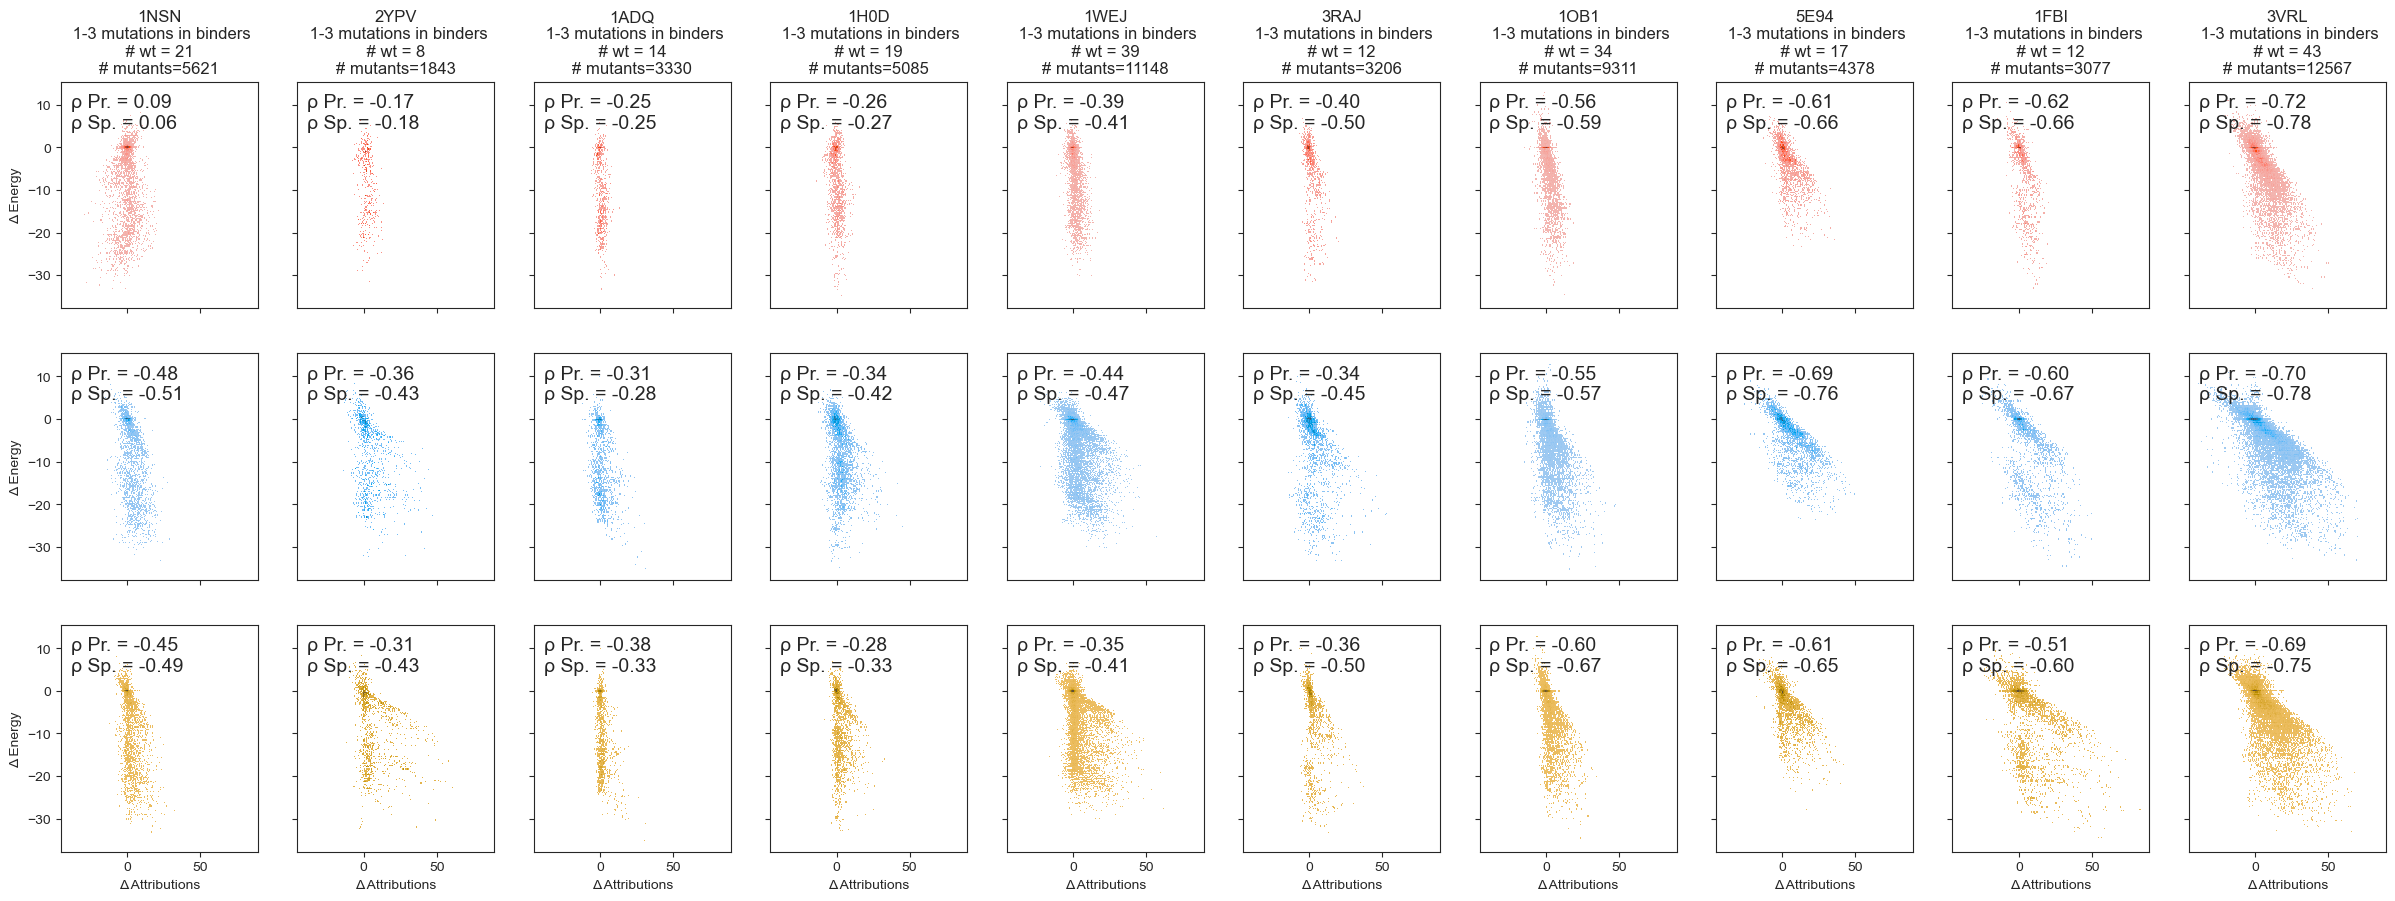

In [1008]:
#for 1-3 mutations
from scipy.stats import spearmanr
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        df_mut_attr = pd.read_csv(f'./mutant_igs/{ag}_{task}_1-3mut_deelift.csv')
        #plot
        n = df_mut_attr.shape[0]
        n_wt = len(df_mut_attr['original Slide'].unique())
        color = get_color(task)
        sns.histplot(df_mut_attr, x ='delta attr', y='dEnergy', color=color, ax=ax[i,j], bins=150, legend=False)
        r_sp = spearmanr(df_mut_attr['delta attr'].values, df_mut_attr['dEnergy'].values).correlation
        r = np.corrcoef(df_mut_attr['delta attr'].values, df_mut_attr['dEnergy'].values)[0,1]
        ax[i,j].text(0.05, 0.95, 'ρ Pr. = {:.2f}\nρ Sp. = {:.2f}'.format(r, r_sp), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        #rename x-axis
        ax[2,j].set_xlabel('Δ Attributions')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(f'{ag}\n 1-3 mutations in binders\n # wt = {n_wt} \n# mutants={n}')


In [1004]:
df_mut_attr

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,n_mut,ID,original Slide,Energy org,dEnergy,mut positions,binding class,mut OH,attr mut,attr wt,delta attr
0,SHH17238587_00a_1m_174_01a,CCRIGLLLRVFDYW,False,CRIGLLLRVFD,-98.73,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,0.92,[0],Binder,"[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0....",[-0.06967852 -0.47667009 1.15287995 -1.041201...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,0.504469
1,SHH17238587_00a_1m_175_01a,CDRIGLLLRVFDYW,False,DRIGLLLRVFD,-96.30,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,-1.51,[0],Weak,"[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0....",[-5.7117486 -2.62995267 4.50973034 -4.948318...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,0.470335
2,SHH17238587_00a_1m_176_01a,CERIGLLLRVFDYW,False,ERIGLLLRVFD,-96.49,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,-1.32,[0],Binder,"[array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0....",[-6.9844408 -3.42454386 5.51936388 -5.786469...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,0.935257
3,SHH17238587_00a_1m_177_01a,CHRIGLLLRVFDYW,False,HRIGLLLRVFD,-97.44,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,-0.37,[0],Binder,"[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0....",[-4.96921635 -2.48174191 4.78706455 -3.859172...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,0.772220
4,SHH17238587_00a_1m_178_01a,CIRIGLLLRVFDYW,False,IRIGLLLRVFD,-99.94,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,2.13,[0],Binder,"[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0....",[ 0.43849817 -0.16025552 0.40274316 -0.458515...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,1.333038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12562,H_H1698108_05a_3m_11_01a,CARRCFLFLCWYFDVW,False,ARRCFLFLCWY,-100.25,137570-BSDLRDDSLU,3.0,1698108_05a,ARRCWLLLGWY,-97.09,3.16,"[4, 6, 8]",Binder,"[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0....",[-1.76850164 -1.1884532 0.35703221 0.801368...,[-8.25117683 -5.25451899 -3.28407216 -0.847971...,-8.708339
12563,H_H1698108_05a_3m_12_01a,CARRCFLLFCWYFDVW,False,ARRCFLLFCWY,-100.24,137570-BSDLRDDSLU,3.0,1698108_05a,ARRCWLLLGWY,-97.09,3.15,"[4, 7, 8]",Binder,"[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0....",[-1.34559178 -0.928837 0.3705788 0.611142...,[-8.25117683 -5.25451899 -3.28407216 -0.847971...,-5.553420
12564,H_H1698108_05a_3m_40_01a,CARRCLLLLWTYFDVW,False,ARRCLLLLWTY,-96.48,137570-BSDLRDDSLU,3.0,1698108_05a,ARRCWLLLGWY,-97.09,-0.61,"[4, 8, 9]",Binder,"[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0....",[-4.34060717 -2.57193422 -1.69012964 -0.486265...,[-8.25117683 -5.25451899 -3.28407216 -0.847971...,-2.112008
12565,H_H1698108_05a_3m_51_01a,CARRCWKWPGWYFDVW,False,ARRCWKWPGWY,-73.54,137570-BLDSRRSURS,3.0,1698108_05a,ARRCWLLLGWY,-97.09,-23.55,"[5, 6, 7]",Non-binder,"[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0....",[ -8.56899071 -5.21051598 -4.40836143 -1.61...,[-8.25117683 -5.25451899 -3.28407216 -0.847971...,56.598727


In [1149]:
preprocess_and_eval(df_mut_attr['attr mut'].iloc[1])

SyntaxError: invalid syntax (<unknown>, line 1)

In [1194]:
df_mut_attr['attr mut'].apply(preprocess_and_eval).iloc[0][0]

-0.06967852

In [1186]:
def preprocess_and_eval(x):
    # Replace '\n' with space and add commas between elements
    x = x.replace('\n', '')
    x = x.replace('[ ', '[')
    x = x.replace(' ]', ']')
    x = re.sub(r'\s+', ' ', x)
    x = x.split(' ')
    x = ','.join(x)
    x = re.sub(r'\[,', '[', x)
    x = re.sub(r',\]', ']', x)
    x = re.sub(r',,', ',', x)
    return ast.literal_eval(x)

In [1219]:
def get_delta_weighted_attr(attrs_wt, attrs_mut, position):
    weighted_attr_mut = attrs_mut[position[0]]/np.sum(np.array(attrs_mut))
    df_mut_attr_wt = attrs_wt[position[0]]/np.sum(np.array(attrs_wt))
    
    return np.log(df_mut_attr_wt - weighted_attr_mut)

In [1217]:
np.corrcoef(df_mut_attr['delta pos attr'].values, df_mut_attr['dEnergy'].values)[0,1]

nan

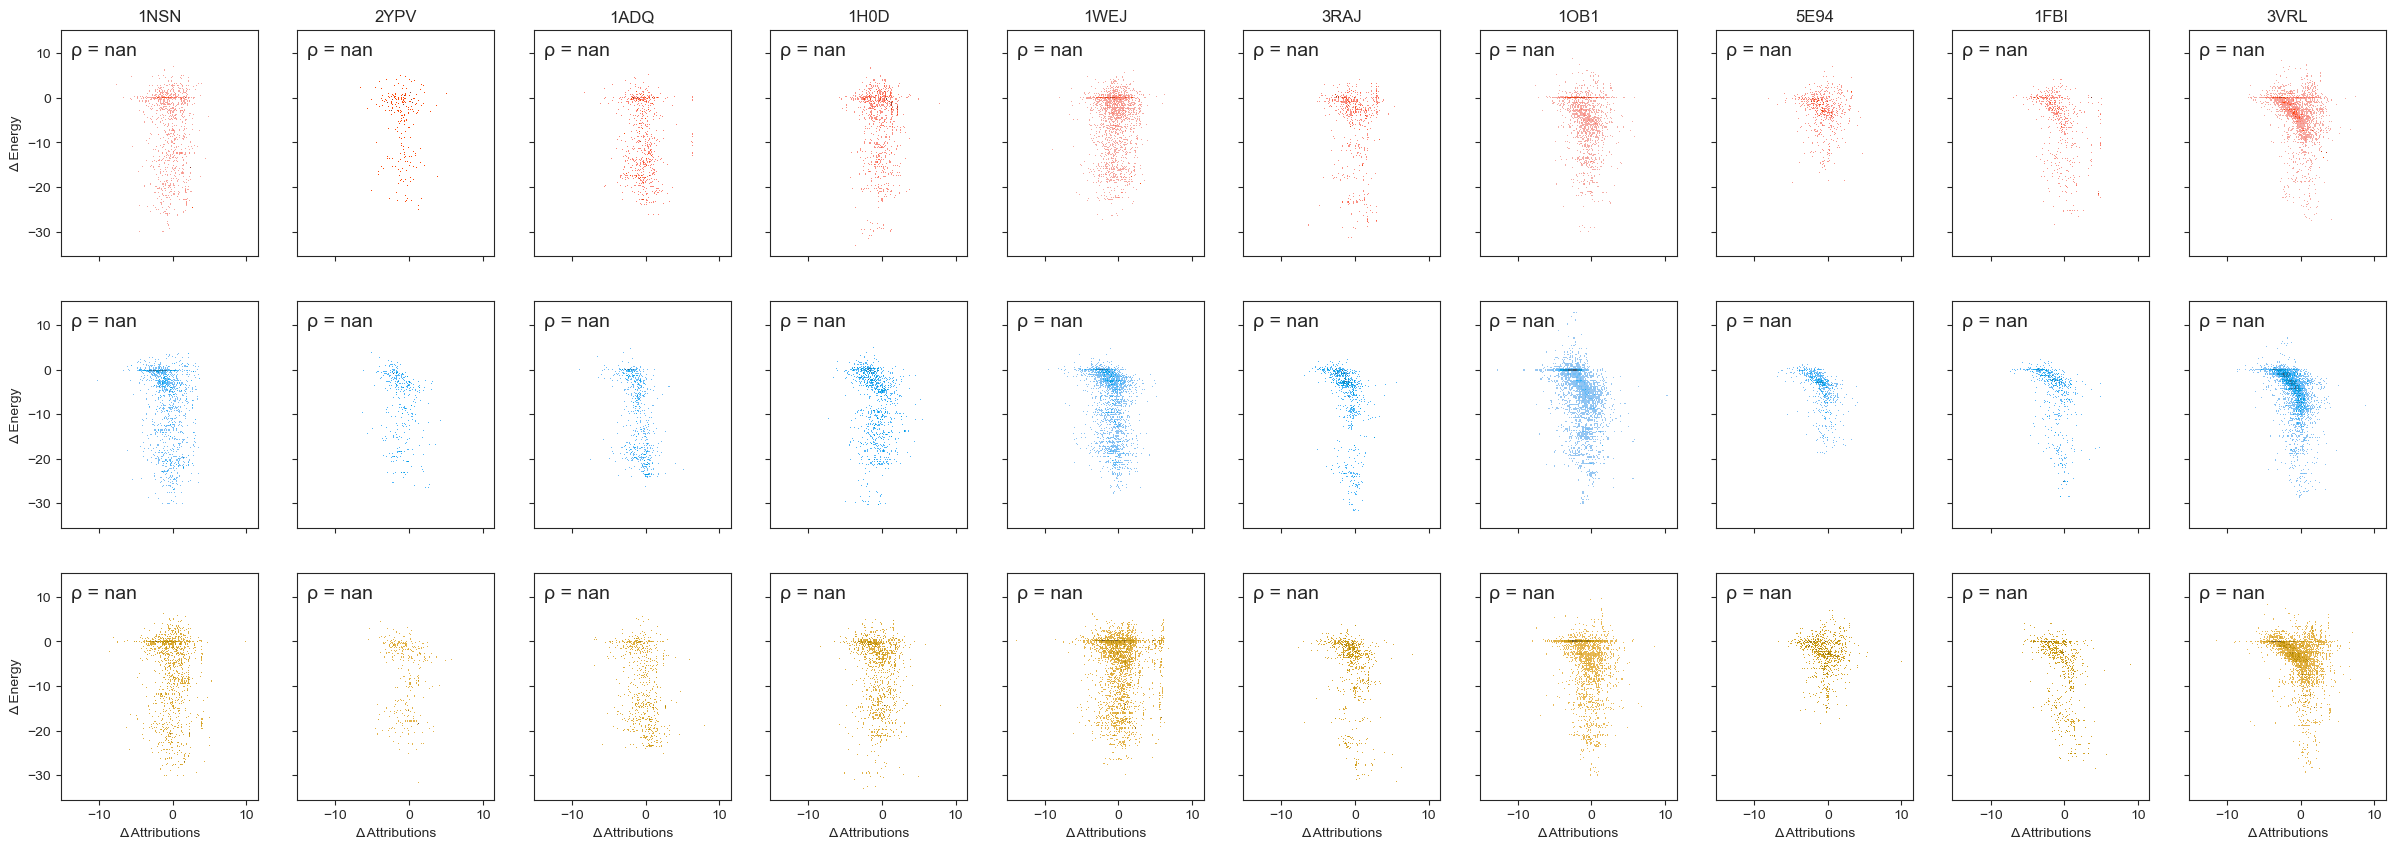

In [1220]:
#for 1-3 mutations
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        df_mut_attr = pd.read_csv(f'./mutant_igs/{ag}_{task}_1-3mut_deelift.csv')
        df_mut_attr = df_mut_attr[df_mut_attr['n_mut'] == 1]
        df_mut_attr['attr mut'] = df_mut_attr['attr mut'].apply(lambda x: preprocess_and_eval(x))
        df_mut_attr['attr wt'] =  df_mut_attr['attr wt'].apply(lambda x: preprocess_and_eval(x))
        df_mut_attr['mut positions'] = df_mut_attr['mut positions'].apply(eval)
        df_mut_attr['delta pos attr'] = df_mut_attr.apply(lambda x: get_delta_weighted_attr(x['attr wt'], x['attr mut'], x['mut positions']), axis=1)

        #plot
        color = get_color(task)
        sns.histplot(df_mut_attr, x ='delta pos attr', y='dEnergy',color=color, ax=ax[i,j], bins=150)
        r = np.corrcoef(df_mut_attr['delta pos attr'].values, df_mut_attr['dEnergy'].values)[0,1]
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}'.format(r), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        #rename x-axis
        ax[2,j].set_xlabel('Δ Attributions')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(f'{ag}')

In [1003]:
df_mut_attr.head()

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,n_mut,ID,original Slide,Energy org,dEnergy,mut positions,binding class,mut OH,attr mut,attr wt,delta attr
0,SHH17238587_00a_1m_174_01a,CCRIGLLLRVFDYW,False,CRIGLLLRVFD,-98.73,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,0.92,[0],Binder,"[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0....",[-0.06967852 -0.47667009 1.15287995 -1.041201...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,0.504469
1,SHH17238587_00a_1m_175_01a,CDRIGLLLRVFDYW,False,DRIGLLLRVFD,-96.30,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,-1.51,[0],Weak,"[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0....",[-5.7117486 -2.62995267 4.50973034 -4.948318...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,0.470335
2,SHH17238587_00a_1m_176_01a,CERIGLLLRVFDYW,False,ERIGLLLRVFD,-96.49,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,-1.32,[0],Binder,"[array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0....",[-6.9844408 -3.42454386 5.51936388 -5.786469...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,0.935257
3,SHH17238587_00a_1m_177_01a,CHRIGLLLRVFDYW,False,HRIGLLLRVFD,-97.44,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,-0.37,[0],Binder,"[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0....",[-4.96921635 -2.48174191 4.78706455 -3.859172...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,0.772220
4,SHH17238587_00a_1m_178_01a,CIRIGLLLRVFDYW,False,IRIGLLLRVFD,-99.94,137569-BDLRDDSLUR,1.0,17238587_00a,ARIGLLLRVFD,-97.81,2.13,[0],Binder,"[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0....",[ 0.43849817 -0.16025552 0.40274316 -0.458515...,[-4.1818552 -2.0774703 3.64452815 -4.278932...,1.333038


In [1102]:
#calculate acc
#constract balanced dataset

acc_mut_list = []
n=304
for ag in config.ANTIGENS:
    acc_mut_dict[ag] = dict()
    test_mut_data = pd.read_csv(f'./mutant_igs/{ag}_1-3mut.csv')
    pos_data = test_mut_data[test_mut_data["binding class"] == 'Binder'].sample(n=2*n, random_state=0)
    neg_data_nb = test_mut_data[test_mut_data["binding class"] == 'Non-binder'].sample(n=n, random_state=0)
    neg_data_w = test_mut_data[test_mut_data["binding class"] == 'Weak'].sample(n=n, random_state=0)
    neg_data = pd.concat([neg_data_nb,neg_data_w], axis=0)
    assert neg_data.shape[0]==pos_data.shape[0]
    neg_data['y'] = [0]*neg_data.shape[0]
    pos_data['y'] = [1]*pos_data.shape[0]
    neg_data['X'] = neg_data['Slide'].apply(lambda x: [onehot_encode(x)])
    pos_data['X'] = pos_data['Slide'].apply(lambda x: [onehot_encode(x)])
    test_data = pd.concat([pos_data,neg_data], axis=0)
    for task in tasks:
        for seed_id in [0,1,2,3]:
            for split_id in [0,1,2,3,4,42]:
                #get_best_model_seed_split(perf_df, task, task, ag, 'acc')
                try:
                    model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
                    model = torch.load(model_path, map_location=torch.device('cpu'))
                    X = torch.tensor(test_data['X'].tolist(), dtype=torch.float32).to("cpu")
                    y_pred= model(X, return_logits = False)
                    test_data['pred y'] = y_pred.cpu().detach().numpy().reshape(-1)
                    test_data['pred y'] = test_data['pred y'].apply(round)
                    acc = (test_data['pred y'] == test_data['y']).value_counts().loc[True]/(n*4)
                    #acc_mut_dict[ag].update({task: acc})
                    acc_mut_list.append([ag, task, seed_id, split_id, acc])
                except:
                    pass

In [1103]:
pd_balanced_acc_mut = pd.DataFrame(acc_mut_list, columns=["ag", "task", "seed_id", "split_id", "acc"]) 

Text(0, 0.5, 'Prediction accuracy')

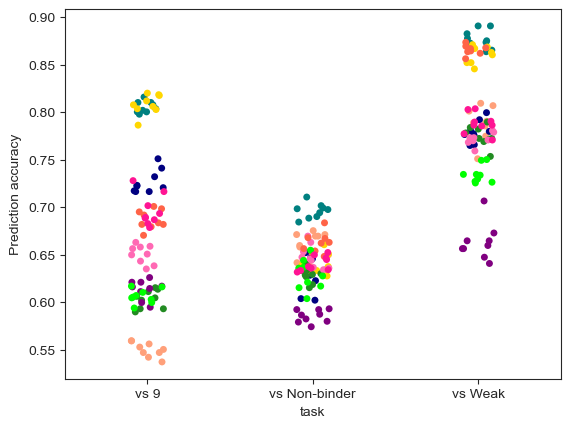

In [1113]:
palette=['#008080','#FFA07A','#000080','#FFD700','#228B22','#FF69B4','#800080','#FF6347','#00FF00','#FF1493']
sns.stripplot(pd_balanced_acc_mut, x='task', y='acc', hue='ag', legend=False, palette=palette)
plt.xticks([0,1,2], ['vs 9', 'vs Non-binder', 'vs Weak'])
plt.ylabel('Prediction accuracy')

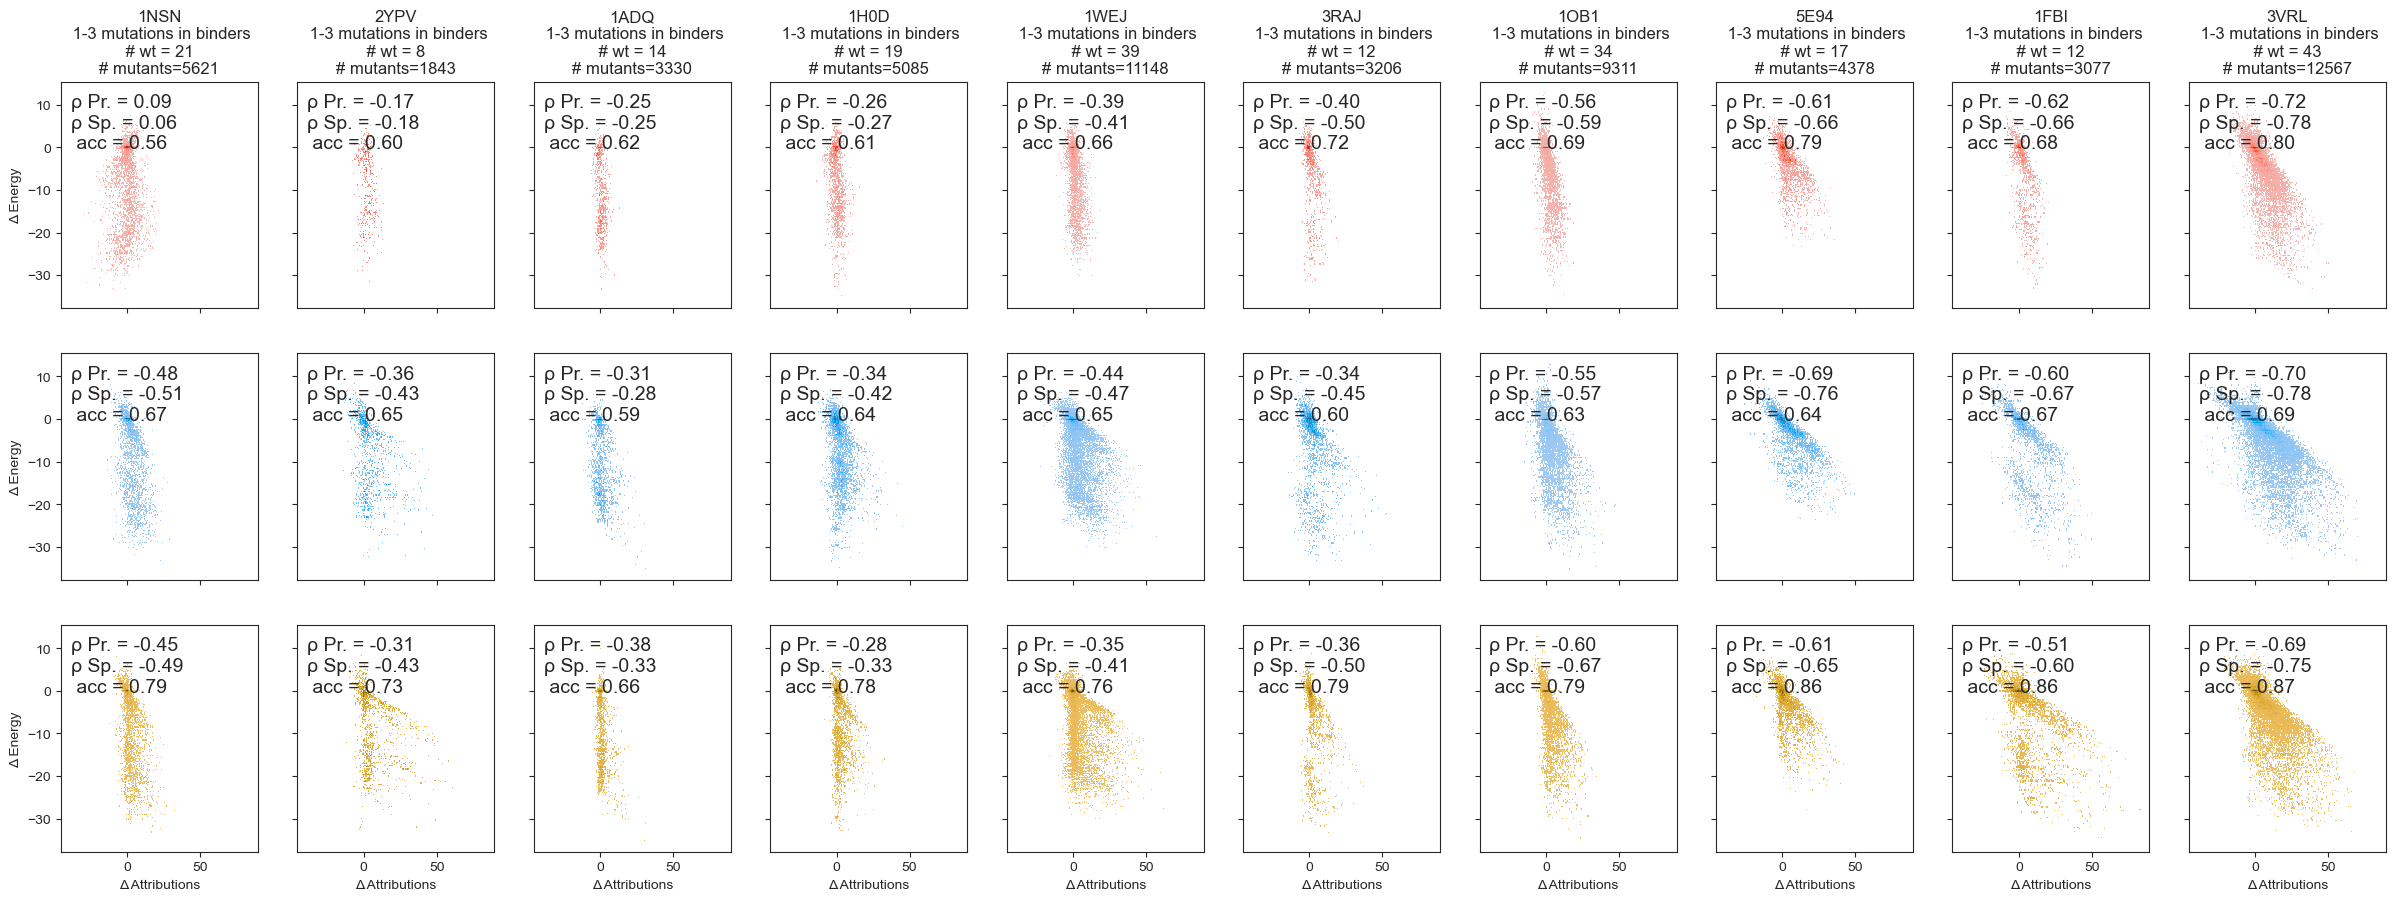

In [1094]:
#for 1-3 mutations
from scipy.stats import spearmanr
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        df_mut_attr = pd.read_csv(f'./mutant_igs/{ag}_{task}_1-3mut_deelift.csv')
        #plot
        n = df_mut_attr.shape[0]
        n_wt = len(df_mut_attr['original Slide'].unique())
        color = get_color(task)
        sns.histplot(df_mut_attr, x ='delta attr', y='dEnergy', color=color, ax=ax[i,j], bins=150, legend=False)
        #r_sp = spearmanr(df_mut_attr['delta attr'].values, df_mut_attr['dEnergy'].values).correlation
        r = np.corrcoef(df_mut_attr['delta attr'].values, df_mut_attr['dEnergy'].values)[0,1]
        ax[i,j].text(0.05, 0.95, 'ρ Pr. = {:.2f}\nρ Sp. = {:.2f}\n acc = {:.2f}'.format(r, r_sp, acc_mut_dict[ag][task]), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        #rename x-axis
        ax[2,j].set_xlabel('Δ Attributions')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(f'{ag}\n 1-3 mutations in binders\n # wt = {n_wt} \n# mutants={n}')